### Spring 2025 ECG Analysis 

##### Modification: switched from rapidHRV to Systole for heart rate preprocessing & peak detection

In [4]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF

import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from scipy.stats import sem
from copy import copy as copy
import operator as operator

import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from functools import reduce

%pylab inline
figsize(5, 5)
import seaborn as sns

import glob

import os
# Added to avoid OMP:error#15
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_66807/322513127.py:13: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr # Pearson's correlation
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['pylab', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
import pathlib
from ecgdetectors import Detectors
import sys
sampleRate = 100
fs = sampleRate
detectors = Detectors(sampleRate)


# Import Dataset

In [6]:
mergedDFClean = pd.read_csv("mergedPhysioAndBehav_Jan2025.csv")
# remove Unamed columns
mergedDFClean = mergedDFClean.loc[:, ~mergedDFClean.columns.str.contains('^Unnamed')]
mergedDFClean['PART_trial'] = mergedDFClean['partNum'].astype(str) + '_' + mergedDFClean['session'].astype(str) + '_' + mergedDFClean['trials'].astype(str)
mergedDFClean = mergedDFClean.dropna()

In [7]:
#screamOn: flagging trials where scream is presented; infoOn: flagging trials where information is chosen

mergedDFClean.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename', 'PART_trial'],
      dtype='object')

# Separate signal by participant

# Preprocess data & detect r-peaks

### Use ECG Detectors (two average detector) for r-peak detection

In [8]:
###Uses two average detector for r peak detectino

def preprocess(delaydata):
    delayProcessed = pd.DataFrame()

    for participant in np.unique(delaydata['partNum']):
        dataPart = delaydata[delaydata['partNum'] == participant].copy()
        time =dataPart['time'].values
        signal = dataPart.EKG.values 
        r_peaks = detectors.pan_tompkins_detector(signal)
        peaks_mask = np.zeros_like(signal, dtype=bool)
        peaks_mask[r_peaks] = True

        dataPart['pEKG'] = signal #same as raw EKG value, changing the name for consistency purposes
        dataPart['peak'] = peaks_mask
        dataPart['peak_time'] = np.where(peaks_mask, time, np.nan)

        delayProcessed = pd.concat([delayProcessed, dataPart], ignore_index=True)

    return delayProcessed

# extract baseline using the start trial period (first 2 seconds)

In [9]:
def IBI_baseline(mergedDFClean):
    dataBaseline = mergedDFClean#.loc[(mergedDFClean['startTrial'] == 1)]
    dataBaseline0= preprocess(dataBaseline)

    ### create baseline IBI for each trial

    rows = []

    for participant in dataBaseline0['partNum'].unique():
        part_data = dataBaseline0[dataBaseline0['partNum'] == participant]
        for session in dataBaseline0['session'].unique():
            sess_data = part_data[part_data['session'] == session]
            
            for trial in sess_data['trials'].unique():
                trial_data = sess_data[sess_data['trials'] == trial]
                part_trial = trial_data['PART_trial'].iloc[0]
                delay      = trial_data['delay_time'].iloc[0]

                
                peak_idxs = np.where(trial_data['peak'])[0]        
                
                
                if len(peak_idxs) < 2:
                    mean_ibi = np.nan

                else:
                    ibi_samples = np.diff(peak_idxs)
                    mean_ibi = ibi_samples.mean()/ sampleRate

                rows.append({
                    'participant': participant,
                    'session': session,
                    'trial': trial,
                    'delay_time':  delay,
                    'baseline': mean_ibi,
                    'PART_trial': part_trial
                    
                })
            
    #return baseline_IBI
    baseline_IBI = pd.DataFrame(rows)

    
    return baseline_IBI


# Compute IBI intervals from before infochoice presentation till after stimulus presentation time

In [10]:
def compute_IBI (data,baseline_df):

    """
    Returns a DataFrame with one row per trial, containing:
      - participant, delay_time, PART_trial
      - IBIs: list of normalized IBIs (s)
      - time_norm: list of IBI timestamps relative to window start (s)
      - cue_norm, stim_norm: cue and stim onsets relative to window start (s)
      *** remove outliers with IBI values > 2 (some trials have recording issues)
    """
    rows = []

    for trials in data['PART_trial'].unique():
        trial_data = data[data['PART_trial']==trials]
        participant = trial_data['partNum'].iloc[0]
        delay = trial_data['delay_time'].iloc[0]

        #extract time point stimInfo or stimNoInfo is presented
        if 'stimInfoOnset' in trial_data.columns and trial_data['stimInfoOnset'].eq(1).any():
            cueTime = trial_data.loc[trial_data['stimInfoOnset']==1, 'time'].iloc[0]
        elif 'stimNoInfoOnset' in trial_data.columns and trial_data['stimNoInfoOnset'].eq(1).any():
            cueTime = trial_data.loc[trial_data['stimNoInfoOnset']==1, 'time'].iloc[0]
        else:
            cueTime = np.nan

        #extract time point scream or noScream is presented
        if 'screamOnset' in trial_data.columns and trial_data['screamOnset'].eq(1).any():
            stimTime = trial_data.loc[trial_data['screamOnset']==1,'time'].iloc[0]
        elif 'noScreamOnset' in trial_data.columns and trial_data['noScreamOnset'].eq(1).any():
            stimTime = trial_data.loc[trial_data['noScreamOnset']==1,'time'].iloc[0]    
        else:
            stimTime = np.nan

        #define start and end time of where ibi values will be extracted
        pre_window = 2.0 #adding 2 sec before infocue onset
        post_window = 4.0 #adding 4 sec after outcome stimulus presentation (outcome pres + end trial time)
        start = cueTime - pre_window
        end = stimTime + post_window

        
        # restrict to peaks in that window
        peak_times = trial_data.loc[trial_data['peak']==1, 'time'].values
        in_window = peak_times[(peak_times >= start) & (peak_times <= end)]
        if len(in_window) < 2:
            continue
        
        #compute raw and normalized ibis
        ibis      = np.diff(in_window)
        ibi_times = (in_window[:-1] + in_window[1:]) / 2

        # —— REMOVE OUTLIERS: drop any IBI > 2 seconds —— 
        mask = ibis < 2.0
        ibis = ibis[mask]
        ibi_times = ibi_times[mask]
        if len(ibis) == 0:
            # nothing left after filtering
            continue

        # —— normalize time to window start —— 
        t_norm     = (ibi_times - start).tolist()
        cue_norm   = cueTime   - start
        stim_norm  = stimTime  - start

        base       = baseline_df.loc[
                         baseline_df['PART_trial']==trials,'baseline'
                     ].iloc[0]
        ibis_norm  = (ibis - base).tolist()

        
        # get this trial’s delay_time (or whatever column you have)
        delay = trial_data['delay_time'].iloc[0]

        
        # collect one row per IBI
        rows.append({
            'participant': participant,
            'delay_time':  delay,
            'PART_trial':  trials,
            'IBIs':        ibis_norm,
            'time_norm':   t_norm,
            'cue_norm':    cue_norm,
            'stim_norm':   stim_norm
        })
        
    return pd.DataFrame(rows)

        
    

# Averaging IBI values over entire delay time on trial & participant levels

In [11]:
import numpy as np
import pandas as pd

def avg_IBI(trial_df,baseline_df):
    """
    From trial_df (output of compute_IBI), compute:
      1) per-trial mean IBI between infoOnset and stimOnset
      2) per-participant x delay mean of those trial means
      3) per-delay mean across participants.

    Returns
    -------
    trial_df2: DataFrame with columns 
        participant, PART_trial, delay_time, mean_IBI
        (df with average across trials)
    part_delay_df : DataFrame with columns
        participant, delay_time, mean_IBI
    delay_df : DataFrame with columns
        delay_time, mean_IBI_across_participants
    """
    # 1) compute per‐trial means
    trial_means = []
    for _, row in trial_df.iterrows():

        ibis  = row['IBIs']
        times = row['time_norm']
        c, s  = row['cue_norm'], row['stim_norm']
        # select only the IBIs whose midpoint lies between cue and stim
        sel   = [ibi for ibi, t in zip(ibis, times) if c <= t <= s]
        if not sel:
            continue

        mean_norm    = np.mean(sel)
        baseline     = baseline_df.loc[
                           baseline_df['PART_trial']==row['PART_trial'],
                           'baseline'
                       ].iloc[0]
        mean_raw     = mean_norm + baseline

        trial_means.append({
            'participant': row['participant'],
            'PART_trial': row['PART_trial'],
            'delay_time':  row['delay_time'],
            'mean_IBI':    mean_raw
        })

    trial_df2 = pd.DataFrame(trial_means)

    # 2) average by participant x delay
    part_delay_df = (
        trial_df2
        .groupby(['participant','delay_time'], as_index=False)
        ['mean_IBI']
        .mean()
    )

    # 3) average across participants, per delay
    delay_df = (
        part_delay_df
        .groupby('delay_time', as_index=False)
        ['mean_IBI']
        .mean()
    )

    return trial_df2,part_delay_df, delay_df


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_baseline_raw_ibi(
    baseline1, baseline2, baseline3,
    raw_part1, raw_part2, raw_part3,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
):
    """
    Plot paired baseline vs. raw dots with error bars for each condition,
    one figure per delay.

    baseline ibi value vs. average ibi value during the entire delay period 

    Parameters
    ----------
    baselineX : pd.DataFrame with columns ['participant','delay_time','baseline']
        Trial-level baseline IBIs.
    raw_partX : pd.DataFrame with columns ['participant','delay_time','mean_IBI']
        Participant-level raw IBI means (first output of avg_IBI).
    cond_labels : tuple of 3 condition names in the order of dataframes.
    """
    # --- Summarize baseline: trials→participant→delay ---
    def summarize_baseline(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['baseline'].mean()
        stats = part.groupby('delay_time')['baseline'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_mean', 'sem': f'{label}_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_mean', f'{label}_sem']]

    # --- Summarize raw: participant→delay ---
    def summarize_raw_part(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['mean_IBI'].mean()
        stats = part.groupby('delay_time')['mean_IBI'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_raw_mean', 'sem': f'{label}_raw_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_raw_mean', f'{label}_raw_sem']]

    # baseline summaries
    b1 = summarize_baseline(baseline1, cond_labels[0])
    b2 = summarize_baseline(baseline2, cond_labels[1])
    b3 = summarize_baseline(baseline3, cond_labels[2])
    # raw summaries at participant level
    r1 = summarize_raw_part(raw_part1, cond_labels[0])
    r2 = summarize_raw_part(raw_part2, cond_labels[1])
    r3 = summarize_raw_part(raw_part3, cond_labels[2])

    # merge all on delay_time
    merged = b1.merge(b2, on='delay_time').merge(b3, on='delay_time')
    merged = merged.merge(r1, on='delay_time').merge(r2, on='delay_time').merge(r3, on='delay_time')


    # plotting
    x = np.arange(len(cond_labels))
    offset = 0.05
    for _, row in merged.iterrows():
        delay = row['delay_time']
        base_means = [row[f'{c}_mean'] for c in cond_labels]
        base_sems  = [row[f'{c}_sem']  for c in cond_labels]
        raw_means  = [row[f'{c}_raw_mean'] for c in cond_labels]
        raw_sems   = [row[f'{c}_raw_sem']  for c in cond_labels]

        fig, ax = plt.subplots(figsize=(6,4))
        ax.errorbar(x - offset, base_means, yerr=base_sems,
                    fmt='o', color='C0', label='Baseline', capsize=4)
        ax.errorbar(x + offset, raw_means, yerr=raw_sems,
                    fmt='o', color='C1', label='Raw', capsize=4)
        for xi, b, r in zip(x, base_means, raw_means):
            ax.plot([xi - offset, xi + offset], [b, r],
                    color='gray', linestyle='--', linewidth=1)

        ax.set_xticks(x)
        ax.set_xticklabels(cond_labels)
        ax.set_xlabel('Condition')
        ax.set_ylabel('Mean IBI (s)')
        ax.set_title(f'Change Baseline→Anticipation IBI — Delay {delay}s')
        ax.legend()
        ax.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()

    return merged


In [13]:
def compute_diff_ibi(
    baseline_dfs, raw_trial_dfs, cond_labels, outlier_thresh=3.0
):
    """
    1) Merge trial-level baseline & raw → compute diff per trial
    2) Remove trial diffs beyond ±3 sigma per delay
    3) Average remaining diffs → participant-level diff
    Returns: diff_part_df, diff_trial_df
    """
    all_trials = []
    all_parts  = []

    for b_df, r_df, cond in zip(baseline_dfs, raw_trial_dfs, cond_labels):
        trial = (
            pd.merge(
                b_df[['participant','delay_time','PART_trial','baseline']],
                r_df[['participant','delay_time','PART_trial','mean_IBI']],
                on=['participant','delay_time','PART_trial']
            )
            .assign(diff=lambda df: df['baseline'] - df['mean_IBI'],
                    condition=cond)
        )

        # filter outliers with threshold of 3 sigma per delay
        def _filter(df):
            mu, sigma = df['diff'].mean(), df['diff'].std()
            return df[df['diff'].between(mu - outlier_thresh*sigma, mu + outlier_thresh*sigma)]

        trial_clean = trial.groupby('delay_time', group_keys=False).apply(_filter)
        all_trials.append(trial_clean)

        #participant-level average diff
        part = (
            trial_clean
            .groupby(['participant','delay_time','condition'], as_index=False)['diff']
            .mean()
        )
        all_parts.append(part)

    diff_trial_df = pd.concat(all_trials, ignore_index=True)
    diff_part_df  = pd.concat(all_parts,  ignore_index=True)
    return diff_part_df, diff_trial_df



In [14]:

def plot_diff_ibi(diff_part_df, cond_labels):
    """
    Takes participant-level diffs, computes mean±SEM per delay & condition,
    and plots one error-bar figure per delay.
    """
    x = np.arange(len(cond_labels))

    for delay, grp in diff_part_df.groupby('delay_time'):
        # compute stats
        stats = (
            grp
            .groupby('condition')['diff_z']
            .agg(['mean','std','count'])
            .reindex(cond_labels)        # ensure order
        )
        stats['sem'] = stats['std'] / np.sqrt(stats['count'])

        means = stats['mean'].values
        sems  = stats['sem'].values

        plt.figure(figsize=(6,4))
        plt.errorbar(
            x, means, yerr=sems,
            fmt='o', capsize=4, linewidth=1.5
        )
        plt.xticks(x, cond_labels)
        plt.ylim(-0.6,0.45)
        plt.xlabel('Condition')
        plt.ylabel('Mean(baseline-raw) IBI (s)')
        plt.title(f'IBI Change by Condition — Delay {delay}s')
        plt.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()
    

In [15]:

def plot_overall_diff_ibi(diff_part_df, cond_labels):
    """
    Takes participant-level diffs, computes mean±SEM per delay & condition,
    and plots one error-bar figure per delay.
    """
    x = np.arange(len(cond_labels))

    # compute stats
    stats = (
        diff_part_df
        .groupby('condition')['diff_z']
        .agg(['mean','std','count'])
        .reindex(cond_labels)        # ensure order
    )
    stats['sem'] = stats['std'] / np.sqrt(stats['count'])

    means = stats['mean'].values
    sems  = stats['sem'].values

    plt.figure(figsize=(6,4))
    plt.errorbar(
        x, means, yerr=sems,
        fmt='o', capsize=4, linewidth=1.5
    )
    plt.xticks(x, cond_labels)
    plt.xlabel('Condition')
    plt.ylabel('Mean(baseline-raw) IBI (s)')
    plt.title(f'IBI Change by Condition')
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_diff_ibi_groupedDelay(diff_part_df, cond_labels):
    """
    For each of two delay groups (Short: 5,10s; Long: 20,40s):
      - Compute mean±SEM of diff_z per condition (across all those delays)
      - Plot side-by-side errorbar panels
    """
    # define delay groups
    groups = {
        'Short delay (5-10 s)': [5.0, 10.0],
        'Long delay (20-40 s)': [20.0, 40.0]
    }
    x = np.arange(len(cond_labels))
    
    fig, (ax_short, ax_long) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
    for ax, (grp_name, delays) in zip(
        (ax_short, ax_long),
        groups.items()
    ):
        df_grp = diff_part_df[diff_part_df['delay_time'].isin(delays)]
        
        # aggregate per condition
        stats = (
            df_grp
            .groupby('condition')['diff_z']
            .agg(['mean','std','count'])
            .reindex(cond_labels)
        )
        stats['sem'] = stats['std'] / np.sqrt(stats['count'])
        
        # plot
        ax.errorbar(
            x, stats['mean'], yerr=stats['sem'],
            fmt='o', capsize=5, linewidth=1.5
        )
        ax.set_xticks(x)
        ax.set_xticklabels(cond_labels)
        ax.set_title(grp_name)
        ax.set_xlabel('Condition')
        ax.grid(axis='y', linestyle=':', alpha=0.7)
    
    ax_short.set_ylabel('Mean(diff_z) IBI (s)')
    plt.tight_layout()
    plt.show()


In [17]:

def plot_delay_effect_byCond(diff_part_df, cond_labels):
    """
    For each condition, compute mean±SEM of diff_z across delay_time 
    and plot them in one error‐bar plot.
    
    Parameters
    ----------
    diff_part_df : pd.DataFrame with columns ['participant','delay_time','condition','diff_z']
    cond_labels  : sequence of condition names to plot (and order)
    """
    # 1) get sorted unique delays and an x‐axis
    delays = sorted(diff_part_df['delay_time'].unique())
    x = np.arange(len(delays))

    # 2) one figure per condition
    for cond in cond_labels:
        grp = diff_part_df[diff_part_df['condition'] == cond]

        # 3) compute mean, std, count, sem per delay_time
        stats = (
            grp
            .groupby('delay_time')['diff_z']
            .agg(['mean','std','count'])
            .reindex(delays)  # ensure same order
        )
        stats['sem'] = stats['std'] / np.sqrt(stats['count'])

        # 4) plot
        plt.figure(figsize=(6,4))
        plt.errorbar(
            x, 
            stats['mean'].values, 
            yerr=stats['sem'].values,
            fmt='o', capsize=4, linewidth=1.5
        )
        plt.xticks(x, delays)
        plt.xlabel('Delay Time (s)')
        plt.ylabel(f'Mean diff_z (baseline-raw IBI) — {cond}')
        plt.title(f'Delay Effect for {cond}')
        plt.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()


In [18]:

def plot_delay_effect(diff_part_df):
    """
    Plot overall delay effect collapsing all conditions
    
    Parameters
    ----------
    diff_part_df : pd.DataFrame with columns ['participant','delay_time','condition','diff_z']
    """
    # 1) get sorted unique delays and an x‐axis
    delays = sorted(diff_part_df['delay_time'].unique())
    x = np.arange(len(delays))


    # 3) compute mean, std, count, sem per delay_time
    stats = (
        diff_part_df
        .groupby('delay_time')['diff_z']
        .agg(['mean','std','count'])
        .reindex(delays)  # ensure same order
        )
    stats['sem'] = stats['std'] / np.sqrt(stats['count'])

    # 4) plot
    plt.figure(figsize=(6,4))
    plt.errorbar(
        x, 
        stats['mean'].values, 
        yerr=stats['sem'].values,
        fmt='o', capsize=4, linewidth=1.5
    )
    plt.xticks(x, delays)
    plt.xlabel('Delay Time (s)')
    plt.ylabel(f'Mean diff IBI (baseline-raw IBI)')
    plt.title(f'Overall Delay Effect')
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [19]:
### same function as above but shown in box plots

def plot_diff_boxplots(
    baseline1, baseline2, baseline3,
    raw_trial1, raw_trial2, raw_trial3,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo'),
    outlier_thresh=3.0     # 3σ threshold
):
    """
    1) Compute trial-level diff = baseline - raw IBI
    2) Label each trial with its condition
    3) Remove trial diffs beyond ±3 sigma within each delay_time
    4) Average remaining diffs → participant-level
    5) Boxplot those participant-level diffs per delay
    """
    all_parts = []
    all_trials = []
    
    for b_df, r_df, cond in zip(
        (baseline1, baseline2, baseline3),
        (raw_trial1, raw_trial2, raw_trial3),
        cond_labels
    ):
        # 1) trial-level merge & compute diff
        trial = pd.merge(
            b_df[['participant','delay_time','PART_trial','baseline']],
            r_df[['participant','delay_time','PART_trial','mean_IBI']],
            on=['participant','delay_time','PART_trial']
        )
        trial['diff'] = trial['baseline'] - trial['mean_IBI']
        # 2) annotate condition label at trial level
        trial['condition'] = cond
        
        # 3) filter out trial-level outliers per delay
        def filter_3sigma(df_delay):
            mu, sigma = df_delay['diff'].mean(), df_delay['diff'].std()
            lower, upper = mu - outlier_thresh * sigma, mu + outlier_thresh * sigma
            return df_delay[df_delay['diff'].between(lower, upper)]
        
        trial_clean = (
            trial
            .groupby('delay_time', group_keys=False)
            .apply(filter_3sigma)
        )
        all_trials.append(trial_clean)
        
        # 4) participant-level mean diff
        part = (
            trial_clean
            .groupby(['participant','delay_time','condition'], as_index=False)['diff']
            .mean()
        )
        all_parts.append(part)
    
    # combine conditions
    diff_part_df = pd.concat(all_parts, ignore_index=True)
    diff_trial_df = pd.concat(all_trials,ignore_index=True)
    
    # 5) boxplot for each delay
    for delay, grp in diff_part_df.groupby('delay_time'):
        data = [grp.loc[grp['condition']==c, 'diff'] for c in cond_labels]
        plt.figure(figsize=(7,4))
        plt.boxplot(
            data, labels=cond_labels, notch=True,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', edgecolor='navy'),
            medianprops=dict(color='firebrick', linewidth=2),
            whiskerprops=dict(color='navy'),
            capprops=dict(color='navy'),
            flierprops=dict(marker='o', markerfacecolor='gray', markersize=4, linestyle='none')
        )
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)
        plt.title(f'Participant-Level IBI Diff (baseline – raw)\nDelay = {delay}s')
        plt.xlabel('Condition')
        plt.ylabel('Mean(baseline – raw IBI) [s]')
        plt.tight_layout()
        plt.show()

    return diff_trial_df,diff_part_df

# Preprocess all data

##### call preprocess function to detect r-peaks, append to df
##### call functions to compute baseline and during-trial IBI values (2s before infoCue ~ 2sec after stimulus presentation)
##### dataframes: stimInfo_scream_ibis, stimInfo_noScream_ibis, stimNoInfo_ibis

In [20]:
#preprocess all data to obtain peak values
processed_all = preprocess(mergedDFClean)


In [21]:
processed_all.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename', 'PART_trial', 'pEKG', 'peak', 'peak_time'],
      dtype='object')

In [22]:
#compute baseline values for stimInfo_scream, stimInfo_noScream, and stimNoinfo
baseline_IBI_stimInfo_scream= IBI_baseline(processed_all.loc[(processed_all['startTrial'] == 1)& (processed_all['screamOn'] == 1) & (processed_all['infoOn'] == 1) ])
baseine_IBI_stimInfo_noScream = IBI_baseline(processed_all.loc[(processed_all['startTrial'] == 1)& (processed_all['screamOn'] == 0) & (processed_all['infoOn'] == 1) ])
baseine_IBI_stimNoInfo = IBI_baseline(processed_all.loc[(processed_all['startTrial'] == 1)& (processed_all['infoOn'] == 0) ])


In [23]:
# extract all data for stimInfo_scream, stimInfo_noScream, and stimNoinfo
stimInfo_scream_df = processed_all[(processed_all['screamOn']==1)&(processed_all['infoOn']==1)] 
stimInfo_noScream_df = processed_all[(processed_all['screamOn']==0) & (processed_all['infoOn']==1)]
stimNoInfo_df = processed_all[(processed_all['infoOn']==0)]

In [24]:
#compute ibi values for all data
stimInfo_scream_ibis = compute_IBI(stimInfo_scream_df,baseline_IBI_stimInfo_scream)
stimInfo_noScream_ibis = compute_IBI(stimInfo_noScream_df,baseine_IBI_stimInfo_noScream)
stimNoInfo_ibis = compute_IBI(stimNoInfo_df,baseine_IBI_stimNoInfo)

# Delay Time Average IBI Analaysis
##### For the following steps, data is categorized into three main parts: information scream, information no scream, no information
##### (2 seconds trials are discarded)

##### 1. compute average ibi values by averaging across trials spanning anticipation (delay) time, separated by delay time
##### 2. compute ibi difference between baseline value & trial average on the trial level, then averaging across participants
##### 3. Plot condition & delay effect on ibi diff
##### 4. Stat tests: OLS, Mixed Effect Model, one-way ANOVA, permutation test


In [25]:
trial_avg_stimInfo_scream, part_avg_stimInfo_scream,avg_stimInfo_scream = avg_IBI(stimInfo_scream_ibis,baseline_IBI_stimInfo_scream)
trial_avg_stimInfo_noScream,part_avg_stimInfo_noScream,avg_stimInfo_noScream = avg_IBI(stimInfo_noScream_ibis,baseine_IBI_stimInfo_noScream)
trial_avg_stimNoInfo,part_avg_stimNoInfo, avg_stimNoInfo = avg_IBI(stimNoInfo_ibis,baseine_IBI_stimNoInfo)

   delay_time  Info+Scream_mean       std  count  Info+Scream_sem
0         2.0          0.848511  0.122329     44         0.018442
1         5.0          0.851248  0.111028     42         0.017132
2        10.0          0.847540  0.120387     45         0.017946
3        20.0          0.848823  0.118183     45         0.017618
4        40.0          0.830030  0.117146     37         0.019259
   delay_time  Info+NoScream_mean       std  count  Info+NoScream_sem
0         2.0            0.847331  0.168848     44           0.025455
1         5.0            0.846116  0.128864     44           0.019427
2        10.0            0.832871  0.109850     44           0.016561
3        20.0            0.834152  0.117058     44           0.017647
4        40.0            0.817477  0.099203     38           0.016093
   delay_time  NoInfo_mean       std  count  NoInfo_sem
0         2.0     0.842476  0.106368     43    0.016221
1         5.0     0.830431  0.112165     43    0.017105
2        10.0   

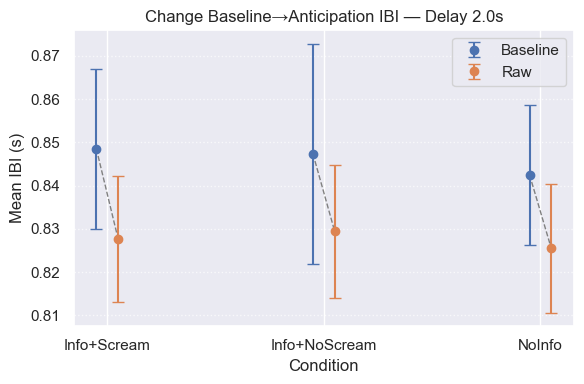

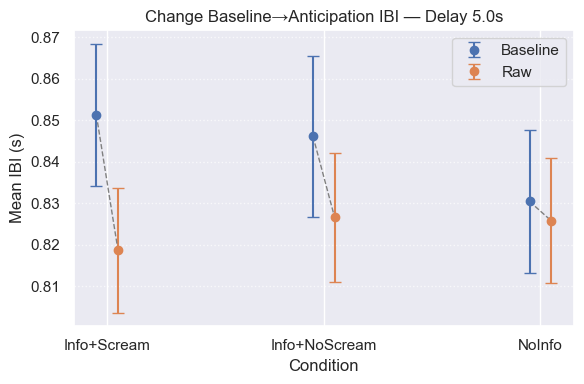

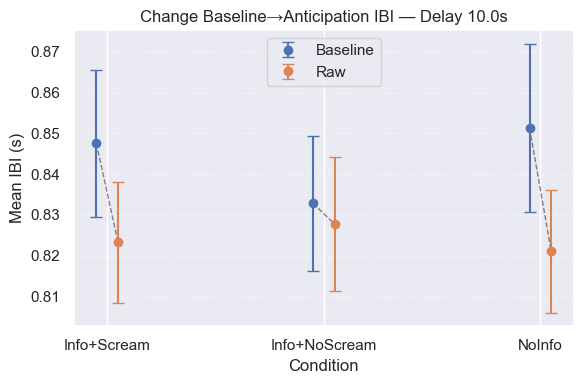

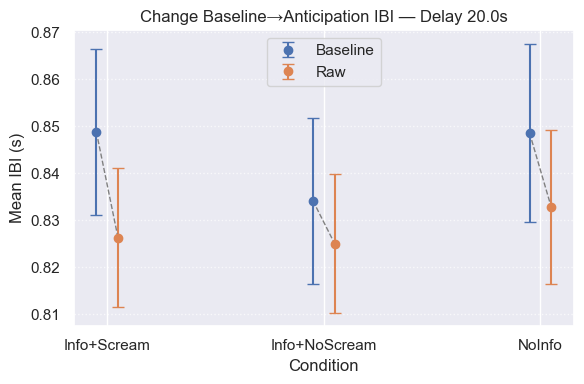

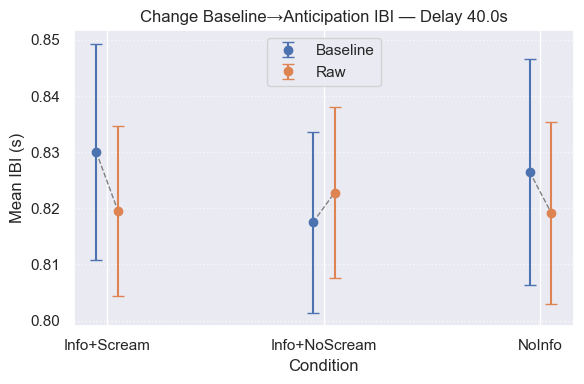

In [26]:
summary_ibi= plot_baseline_raw_ibi(
    baseline_IBI_stimInfo_scream,
    baseine_IBI_stimInfo_noScream,
    baseine_IBI_stimNoInfo,
    part_avg_stimInfo_scream,
    part_avg_stimInfo_noScream,
    part_avg_stimNoInfo,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
)

In [27]:
def plot_change_dots_with_error(
    baseline1, baseline2, baseline3,
    raw_part1, raw_part2, raw_part3,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
):
    """
    Plot paired baseline vs. raw dots with error bars for each condition,
    one figure per delay.

    Parameters
    ----------
    baselineX : pd.DataFrame with columns ['participant','delay_time','baseline']
        Trial-level baseline IBIs.
    raw_partX : pd.DataFrame with columns ['participant','delay_time','mean_IBI']
        Participant-level raw IBI means (first output of avg_IBI).
    cond_labels : tuple of 3 condition names in the order of dataframes.
    """
    # --- Summarize baseline: trials→participant→delay ---
    def summarize_baseline(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['baseline'].mean()
        stats = part.groupby('delay_time')['baseline'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_mean', 'sem': f'{label}_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_mean', f'{label}_sem']]

    # --- Summarize raw: participant→delay ---
    def summarize_raw_part(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['mean_IBI'].mean()
        stats = part.groupby('delay_time')['mean_IBI'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_raw_mean', 'sem': f'{label}_raw_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_raw_mean', f'{label}_raw_sem']]

    # baseline summaries
    b1 = summarize_baseline(baseline1, cond_labels[0])
    b2 = summarize_baseline(baseline2, cond_labels[1])
    b3 = summarize_baseline(baseline3, cond_labels[2])
    # raw summaries at participant level
    r1 = summarize_raw_part(raw_part1, cond_labels[0])
    r2 = summarize_raw_part(raw_part2, cond_labels[1])
    r3 = summarize_raw_part(raw_part3, cond_labels[2])

    # merge all on delay_time
    merged = b1.merge(b2, on='delay_time').merge(b3, on='delay_time')
    merged = merged.merge(r1, on='delay_time').merge(r2, on='delay_time').merge(r3, on='delay_time')

    # plotting
    x = np.arange(len(cond_labels))
    offset = 0.15
    widths = 0.25

    for _, row in merged.iterrows():
        delay = row['delay_time']

        # collect the raw arrays for this delay
        base_data = [
            baseline1.loc[baseline1['delay_time']==delay, 'baseline'],
            baseline2.loc[baseline2['delay_time']==delay, 'baseline'],
            baseline3.loc[baseline3['delay_time']==delay, 'baseline'],
        ]
        raw_data = [
            raw_part1.loc[raw_part1['delay_time']==delay, 'mean_IBI'],
            raw_part2.loc[raw_part2['delay_time']==delay, 'mean_IBI'],
            raw_part3.loc[raw_part3['delay_time']==delay, 'mean_IBI'],
        ]

        fig, ax = plt.subplots(figsize=(6,4))

        # boxplots for baseline (blue) & raw (orange)
        bp1 = ax.boxplot(
            base_data,
            positions = x - offset,
            widths    = widths,
            patch_artist=True,
            boxprops  = dict(facecolor='C0', alpha=0.3),
            medianprops=dict(color='C0'),
            whiskerprops=dict(color='C0'),
            capprops   =dict(color='C0'),
            flierprops =dict(markeredgecolor='C0')
        )
        bp2 = ax.boxplot(
            raw_data,
            positions = x + offset,
            widths    = widths,
            patch_artist=True,
            boxprops  = dict(facecolor='C1', alpha=0.3),
            medianprops=dict(color='C1'),
            whiskerprops=dict(color='C1'),
            capprops   =dict(color='C1'),
            flierprops =dict(markeredgecolor='C1')
        )

        # overlay the means as dots if you like
        base_means = [row[f'{c}_mean'] for c in cond_labels]
        raw_means  = [row[f'{c}_raw_mean'] for c in cond_labels]
        ax.scatter(x - offset, base_means, color='C0', s=50, zorder=3)
        ax.scatter(x + offset, raw_means,  color='C1', s=50, zorder=3)

        ax.set_xticks(x)
        ax.set_xticklabels(cond_labels)
        ax.set_xlabel('Condition')
        ax.set_ylabel('Mean IBI (s)')
        ax.set_title(f'Change Baseline→Raw IBI — Delay {delay}s')

        # legend hack
        ax.plot([], [], color='C0', label='Baseline')
        ax.plot([], [], color='C1', label='Raw')
        ax.legend()

        ax.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()


   delay_time  Info+Scream_mean       std  count  Info+Scream_sem
0         2.0          0.848511  0.122329     44         0.018442
1         5.0          0.851248  0.111028     42         0.017132
2        10.0          0.847540  0.120387     45         0.017946
3        20.0          0.848823  0.118183     45         0.017618
4        40.0          0.830030  0.117146     37         0.019259
   delay_time  Info+NoScream_mean       std  count  Info+NoScream_sem
0         2.0            0.847331  0.168848     44           0.025455
1         5.0            0.846116  0.128864     44           0.019427
2        10.0            0.832871  0.109850     44           0.016561
3        20.0            0.834152  0.117058     44           0.017647
4        40.0            0.817477  0.099203     38           0.016093
   delay_time  NoInfo_mean       std  count  NoInfo_sem
0         2.0     0.842476  0.106368     43    0.016221
1         5.0     0.830431  0.112165     43    0.017105
2        10.0   

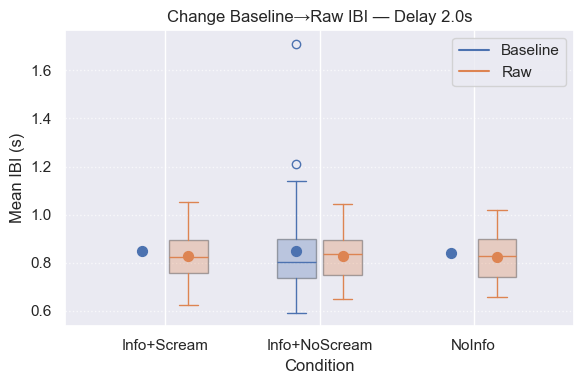

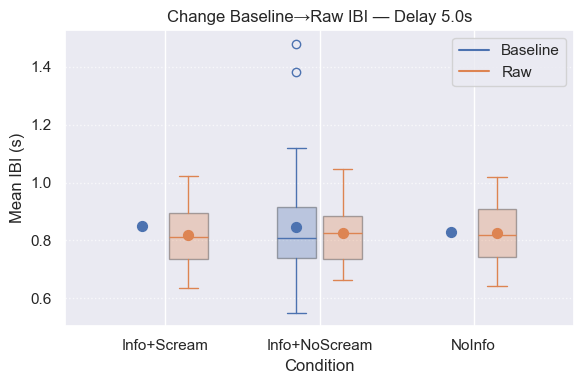

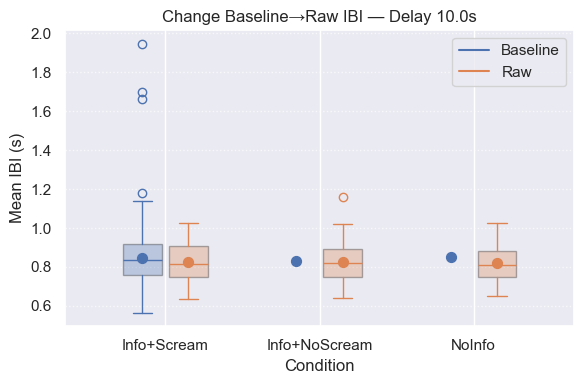

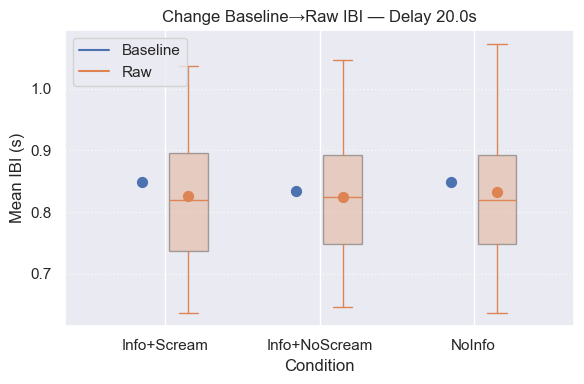

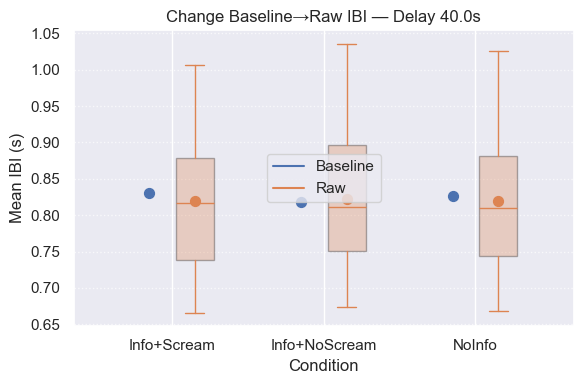

In [28]:
plot_change_dots_with_error(
    baseline_IBI_stimInfo_scream,
    baseine_IBI_stimInfo_noScream,
    baseine_IBI_stimNoInfo,
    part_avg_stimInfo_scream,
    part_avg_stimInfo_noScream,
    part_avg_stimNoInfo,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
)

/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_66807/3727018163.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trial_clean = trial.groupby('delay_time', group_keys=False).apply(_filter)
/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_66807/3727018163.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trial_clean = trial.groupby('delay_time', group_keys=False).apply(_filter)
/v

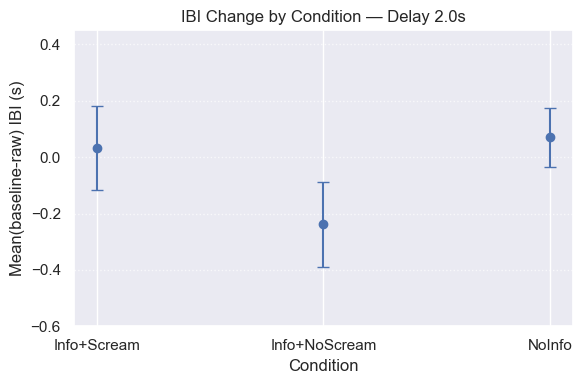

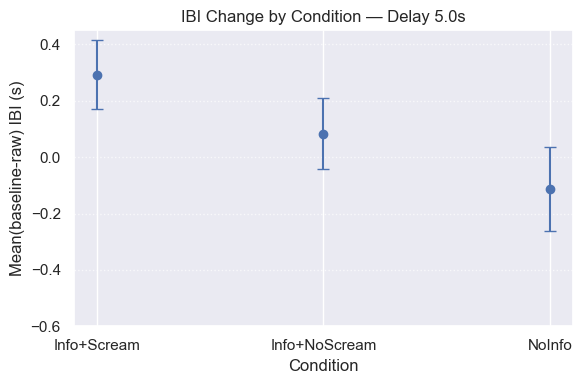

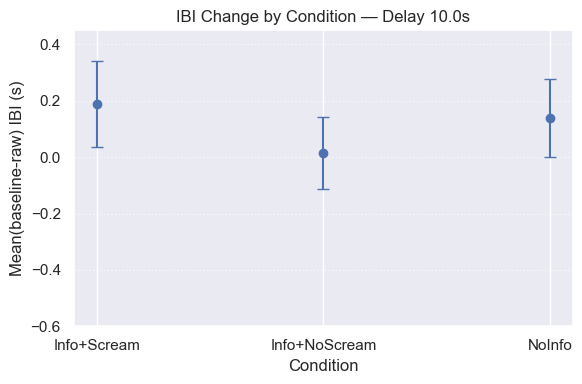

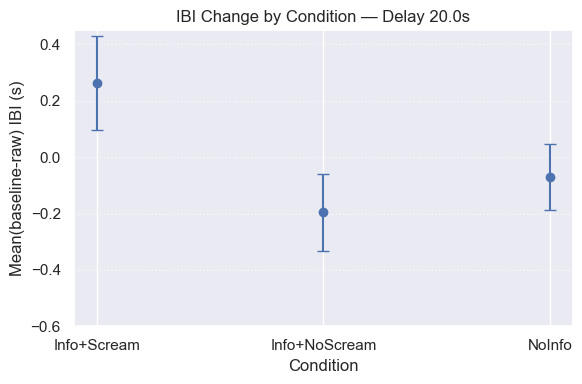

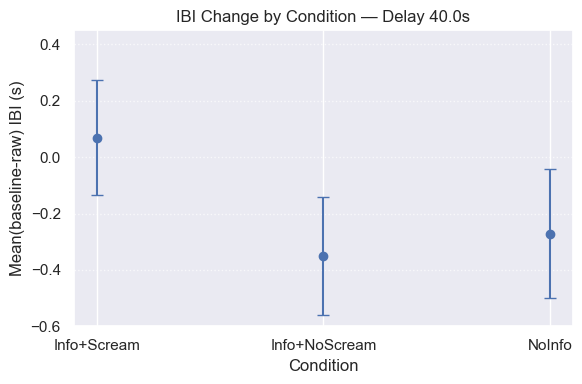

In [29]:
#organize input values to be passed in the compute_diff_ibi function
baselines = [baseline_IBI_stimInfo_scream,baseine_IBI_stimInfo_noScream,baseine_IBI_stimNoInfo]
raw_trials = [trial_avg_stimInfo_scream,trial_avg_stimInfo_noScream,trial_avg_stimNoInfo]
conds=('Info+Scream','Info+NoScream','NoInfo')


part_ibi_diff,trial_ibi_diff = compute_diff_ibi(baselines, raw_trials, conds)

#normalize diff ibi value
part_ibi_diff['diff_z'] = (part_ibi_diff['diff'] - part_ibi_diff['diff'].mean()) / part_ibi_diff['diff'].std()
trial_ibi_diff['diff_z'] = (trial_ibi_diff['diff'] - trial_ibi_diff['diff'].mean()) / trial_ibi_diff['diff'].std()



#plot by condition at part level
plot_diff_ibi(part_ibi_diff, conds)


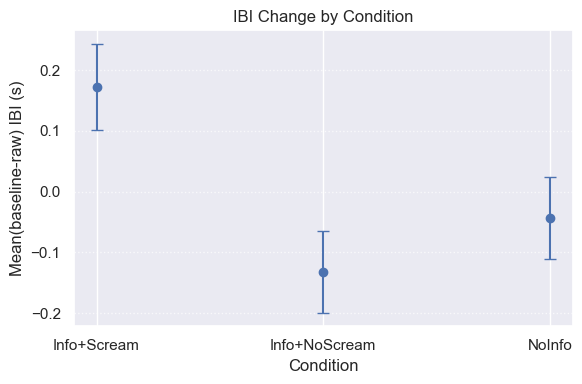

In [30]:
#collapsing delay times 
plot_overall_diff_ibi(part_ibi_diff,conds)

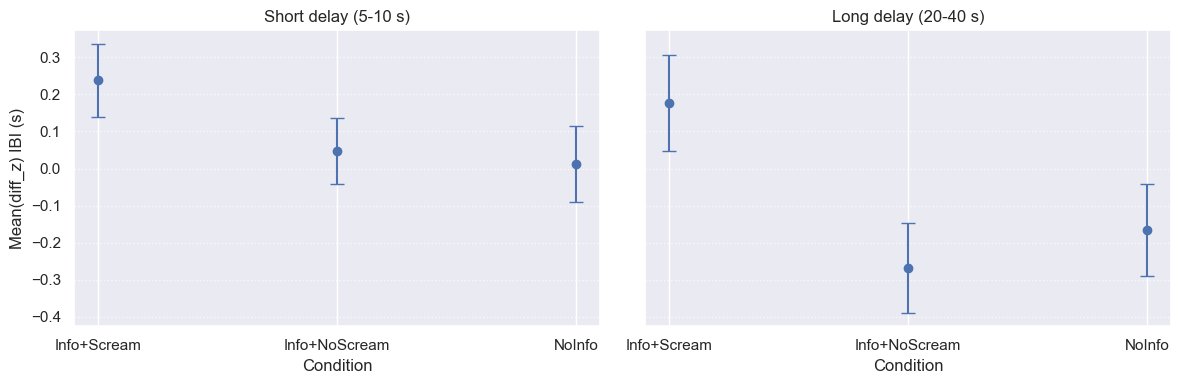

In [31]:
plot_diff_ibi_groupedDelay(part_ibi_diff, conds)

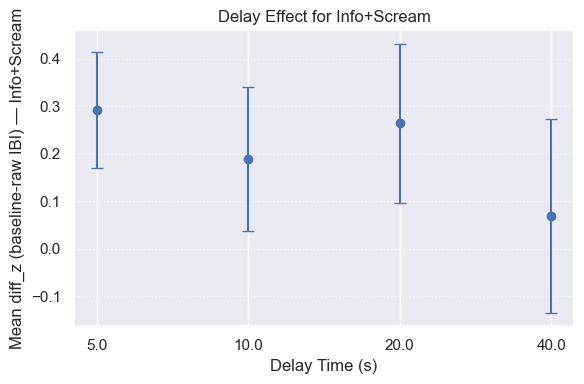

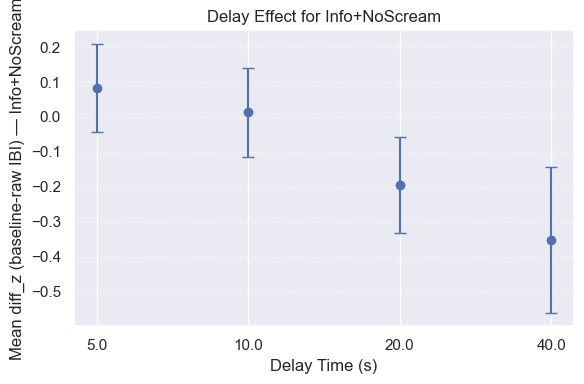

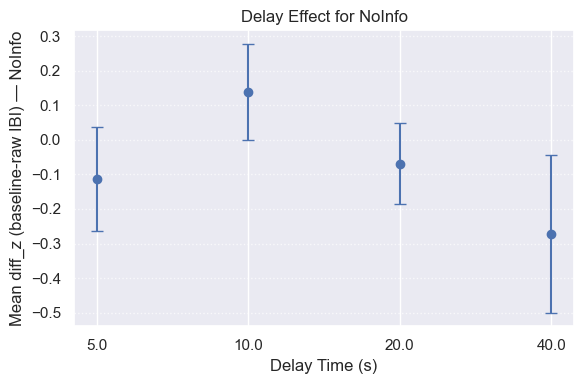

In [32]:
#plot by delay at part level
delay_ibi = part_ibi_diff[part_ibi_diff['delay_time']!=2]
plot_delay_effect_byCond(delay_ibi, conds)


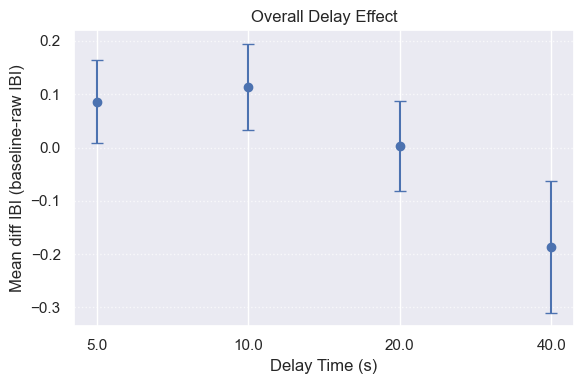

In [33]:
plot_delay_effect(delay_ibi)


### Stat Analysis 

#### Regression

In [34]:
import statsmodels.formula.api as smf

In [35]:
#pick only info scream and info no scream conditions & remove 2 sec conditions
regress_stim_df = trial_ibi_diff[(trial_ibi_diff['condition'] != 'NoInfo') & (trial_ibi_diff['delay_time']!=2)].copy()

In [36]:
regress_stim_df['condition'].unique()

array(['Info+Scream', 'Info+NoScream'], dtype=object)

In [37]:
regress_stim_df

,participant,delay_time,PART_trial,baseline,mean_IBI,diff,condition,diff_z
318,44,5.0,44_0_2,0.570000,0.702857,-0.132857,Info+Scream,-1.947332
319,44,5.0,44_0_13,0.746667,0.690000,0.056667,Info+Scream,0.675686
320,44,5.0,44_1_15,0.723333,0.712857,0.010476,Info+Scream,0.036408
321,44,5.0,44_3_7,0.733333,0.717143,0.016190,Info+Scream,0.115494
322,45,5.0,45_0_1,0.990000,1.002000,-0.012000,Info+Scream,-0.274664
...,...,...,...,...,...,...,...,...
2651,129,40.0,129_3_6,0.770000,0.800600,-0.030600,Info+NoScream,-0.532089
2652,130,40.0,130_2_5,0.660000,0.690714,-0.030714,Info+NoScream,-0.533670
2653,130,40.0,130_2_10,0.690000,0.646250,0.043750,Info+NoScream,0.496919
2654,130,40.0,130_2_12,0.740000,0.717500,0.022500,Info+NoScream,0.202818


In [38]:
###simple OLS


# Fit OLS: diff ~ C(condition) + delay_time
ols_mod = smf.ols(
    formula='diff_z ~ C(condition) + delay_time ',
    data=regress_stim_df
).fit()

print(ols_mod.summary())


                            OLS Regression Results                            
Dep. Variable:                 diff_z   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.420
Date:                Fri, 30 May 2025   Prob (F-statistic):            0.00449
Time:                        14:20:50   Log-Likelihood:                -2858.2
No. Observations:                2039   AIC:                             5722.
Df Residuals:                    2036   BIC:                             5739.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### One way ANOVA


In [39]:
import statsmodels.api as sm

# Fit the model
model = smf.ols('diff ~ C(condition)', data=trial_ibi_diff).fit()

# Type II ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq      df         F    PR(>F)
C(condition)   0.068127     2.0  6.541483  0.001457
Residual      22.516431  4324.0       NaN       NaN


### Mixed Effects

In [40]:
# Fit a mixed model: random intercept by participant
mixed_mod = smf.mixedlm(
    formula='diff ~ C(condition) + delay_time',
    data=regress_stim_df,
    groups=regress_stim_df['participant']
).fit()

print(mixed_mod.summary())


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      diff     
No. Observations:      2039         Method:                  REML     
No. Groups:            45           Scale:                   0.0049   
Min. group size:       8            Log-Likelihood:          2492.0336
Max. group size:       87           Converged:               Yes      
Mean group size:       45.3                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.012    0.004  3.377 0.001  0.005  0.020
C(condition)[T.Info+Scream]  0.007    0.003  2.243 0.025  0.001  0.013
delay_time                  -0.000    0.000 -2.231 0.026 -0.001 -0.000
Group Var                    0.000    0.001                           



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


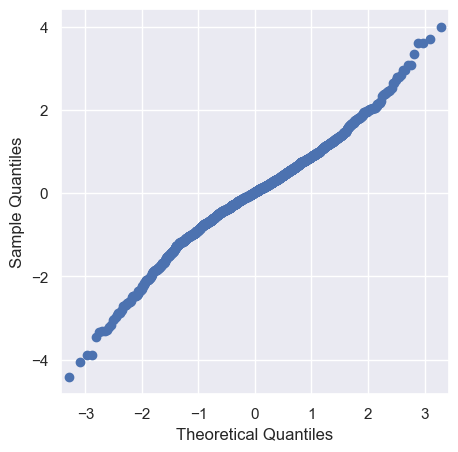

In [41]:
import scipy.stats as st
import statsmodels.api as sm
sm.qqplot(ols_mod.resid)
plt.show()


In [42]:
#optional: lmer test

### Permutation Test

In [43]:
def permutation_test(
    df,
    cond1,
    cond2,
    value_col='diff',
    n_permutations=10000,
    random_state=None
):
    """
    Performs a two-sided permutation test for the difference in means
    between df[value_col] under cond1 vs cond2.
    Returns: observed_diff, p_value, all_permuted_diffs
    """
    rng = np.random.default_rng(random_state)
    # extract the two samples
    x = df.loc[df['condition']==cond1, value_col].values
    y = df.loc[df['condition']==cond2, value_col].values
    obs_diff = x.mean() - y.mean()

    pooled = np.concatenate([x, y])
    n1 = len(x)
    perm_diffs = np.empty(n_permutations)

    for i in range(n_permutations):
        perm = rng.permutation(pooled)
        perm_diffs[i] = perm[:n1].mean() - perm[n1:].mean()

    # two‐sided p‐value
    p_val = np.mean(np.abs(perm_diffs) >= abs(obs_diff))
    return obs_diff, p_val, perm_diffs

# ——— overall test ———
obs, p, perm_diffs = permutation_test(
    regress_stim_df, 
    'Info+Scream', 
    'Info+NoScream',
    value_col='diff',
    n_permutations=5000,
    random_state=42
)
print(f"Overall: Δmean = {obs:.4f}s, permutation p = {p:.4f}")

# ——— stratified by delay_time ———
results = []
for delay, grp in regress_stim_df.groupby('delay_time'):
    seed = int(delay)   # turn 2.0 → 2
    obs_d, p_d, _ = permutation_test(
        grp,
        'Info+Scream', 'Info+NoScream',
        value_col='diff',
        n_permutations=2000,
        random_state=seed
    )
    results.append({'delay_time': delay, 
                    'obs_diff': obs_d, 
                    'p_value': p_d})
    
res_df = pd.DataFrame(results).sort_values('delay_time')
print(res_df)


Overall: Δmean = 0.0073s, permutation p = 0.0198
   delay_time  obs_diff  p_value
0         5.0  0.004016   0.4900
1        10.0  0.002688   0.6455
2        20.0  0.010660   0.0650
3        40.0  0.019738   0.0585


## Picking 3 beats around info cue and stim presentation time

### Functions

In [44]:
def extract_event_beats(df_ibis):
    """
    For each row in df, find:
      - cue_event_idx = first i where time_norm >= cue_norm
      - stim_event_idx = first i where time_norm >= stim_norm
    Then extract:
      * cue_minus1, cue_event, cue_plus1, cue_plus2
      * stim_minus1, stim_event, stim_plus1, stim_plus2
    Returns a DataFrame with those 8 columns + participant, delay_time, PART_trial, condition.
    """
    recs = []
    for _, row in df_ibis.iterrows():
        ibis  = np.array(row['IBIs'],     dtype=float)
        times = np.array(row['time_norm'], dtype=float)
        cue   = row['cue_norm']
        stim  = row['stim_norm']

        def window_around(event_time):
            # find first index after event_time
            idxs = np.where(times >= event_time)[0]
            if idxs.size == 0:
                return [np.nan]*4
            ev = idxs[0]
            window = [ev-1, ev, ev+1, ev+2]
            return [ibis[i] if 0 <= i < len(ibis) else np.nan for i in window]

        cue_w  = window_around(cue)
        stim_w = window_around(stim)

        recs.append({
            'participant':     row['participant'],
            'delay_time':      row['delay_time'],
            'PART_trial':      row['PART_trial'],
            'cue_minus1':      cue_w[0],
            'cue_event':       cue_w[1],
            'cue_plus1':       cue_w[2],
            'cue_plus2':       cue_w[3],
            'stim_minus1':     stim_w[0],
            'stim_event':      stim_w[1],
            'stim_plus1':      stim_w[2],
            'stim_plus2':      stim_w[3]
        })
    return pd.DataFrame(recs)


In [45]:
def plot_event_beats(extracted_dict, cond_labels):
    """
    For each delay and each condition:
      1) Group by participant → participant-level mean 4-beat window
      2) Across participants → grand mean±SEM
      3) Plot cue & stim windows side-by-side, with legend at top
    """
    # get sorted list of delay times
    delays = sorted({
        dt for df in extracted_dict.values() for dt in df['delay_time'].unique()
    })

    # define custom color mapping
    color_map = {
        'Info+Scream': '#FA8072',
        'Info+NoScream': '#008080',
        'NoInfo': '#069AF3'
    }


    for delay in delays:
        fig, (ax_cue, ax_stim) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

        x = np.arange(4)
        labels = ['-1','event','+1','+2']
        cue_cols  = ['cue_minus1','cue_event','cue_plus1','cue_plus2']
        stim_cols = ['stim_minus1','stim_event','stim_plus1','stim_plus2']

        handles = []
        for cond in cond_labels:
            df = extracted_dict[cond]
            df_d = df[df['delay_time'] == delay]

            # 1) participant‑level means
            p_cue  = df_d.groupby('participant')[cue_cols].mean()
            p_stim = df_d.groupby('participant')[stim_cols].mean()

            # 2) grand mean & SEM
            y_c  = p_cue.mean()
            se_c = p_cue.sem()
            y_s  = p_stim.mean()
            se_s = p_stim.sem()

            # choose color
            color = color_map.get(cond, 'black')

            # 3) plot and collect handle for legend (first element of return)
            line_cue = ax_cue.errorbar(
                x, y_c, yerr=se_c,
                fmt='-o', color = color,label=cond
            )[0]
            ax_stim.errorbar(
                x, y_s, yerr=se_s, color = color,
                fmt='-o'
            )
            handles.append(line_cue)

            # highlight the event beat
            ax_cue.scatter([1], [y_c.iloc[1]], s=100,
                           facecolors='none', edgecolors='k', linewidths=1.5)
            ax_stim.scatter([1], [y_s.iloc[1]], s=100,
                            facecolors='none', edgecolors='k', linewidths=1.5)

        # finalize axes
        for ax, title in zip((ax_cue, ax_stim),
                             ('Cue Onset', 'Stim Onset')):
            ax.set_xticks(x)
            ax.set_xticklabels(labels)
            ax.set_xlabel(title)
        ax_cue.set_ylabel('IBI (s)')
        fig.suptitle(f'Delay = {delay}s', y=1.02)

        # figure‑level legend using the collected handles
        fig.legend(
            handles, cond_labels,
            loc='upper center', bbox_to_anchor=(0.5, 1.10),
            ncol=len(cond_labels), frameon=False
        )

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()



### Implementation

Using raw IBI - baseline (start of the trial 2s)

In [46]:
stimInfo_scream_beats = extract_event_beats(stimInfo_scream_ibis)
stimInfo_noScream_beats = extract_event_beats(stimInfo_noScream_ibis)
stimNoInfo_beats = extract_event_beats(stimNoInfo_ibis)

In [47]:
# 1) Tag each with its condition
stimInfo_scream_beats['condition']   = 'Info+Scream'
stimInfo_noScream_beats['condition'] = 'Info+NoScream'
stimNoInfo_beats['condition']        = 'NoInfo'

# 2) Concatenate, remove 2 sec trials
all_beats_df = pd.concat([
    stimInfo_scream_beats,
    stimInfo_noScream_beats,
    stimNoInfo_beats
], ignore_index=True)

all_beats_df = all_beats_df[all_beats_df['delay_time'] !=2]

# 3) Convert to dict, keyed by condition
cond_labels = ['Info+Scream','Info+NoScream','NoInfo']
combined_beats_dict = {
    cond: all_beats_df[all_beats_df['condition'] == cond]
                 .reset_index(drop=True)
    for cond in cond_labels
}


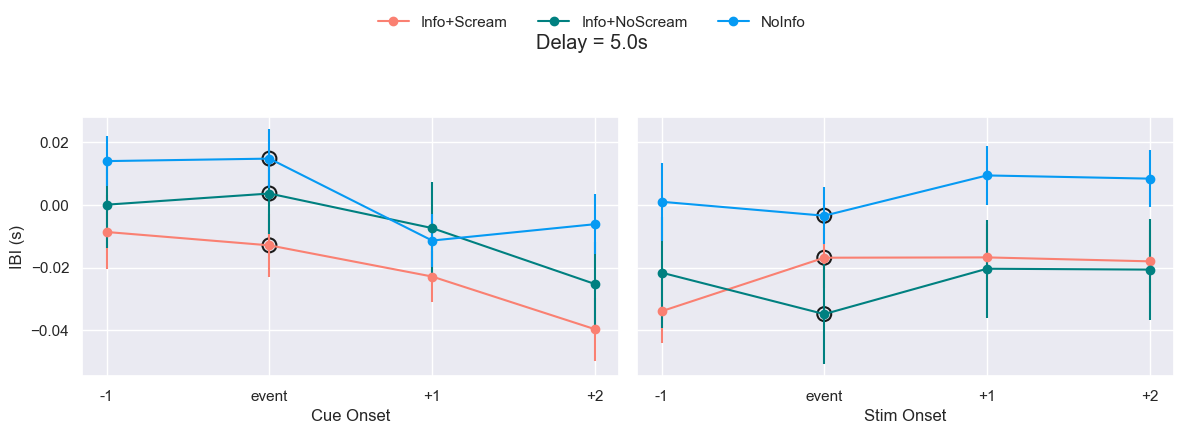

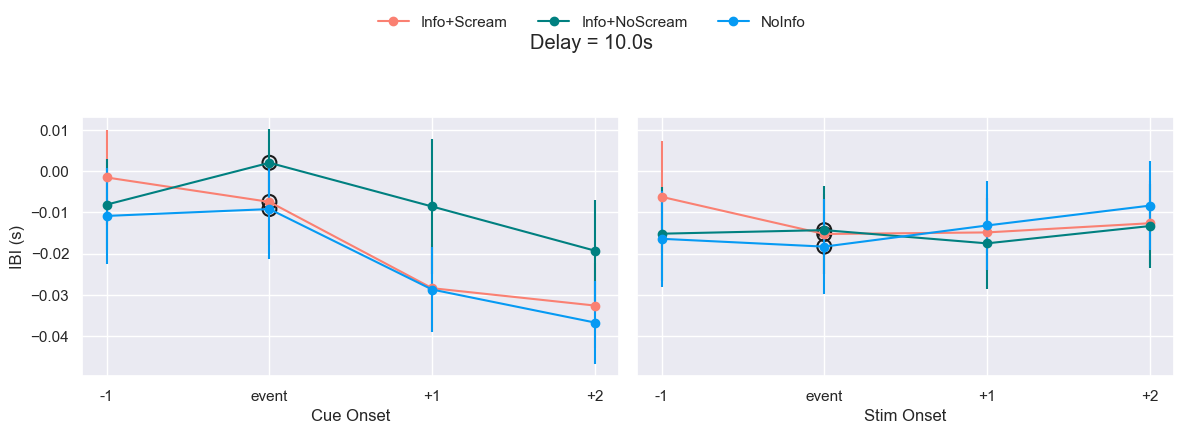

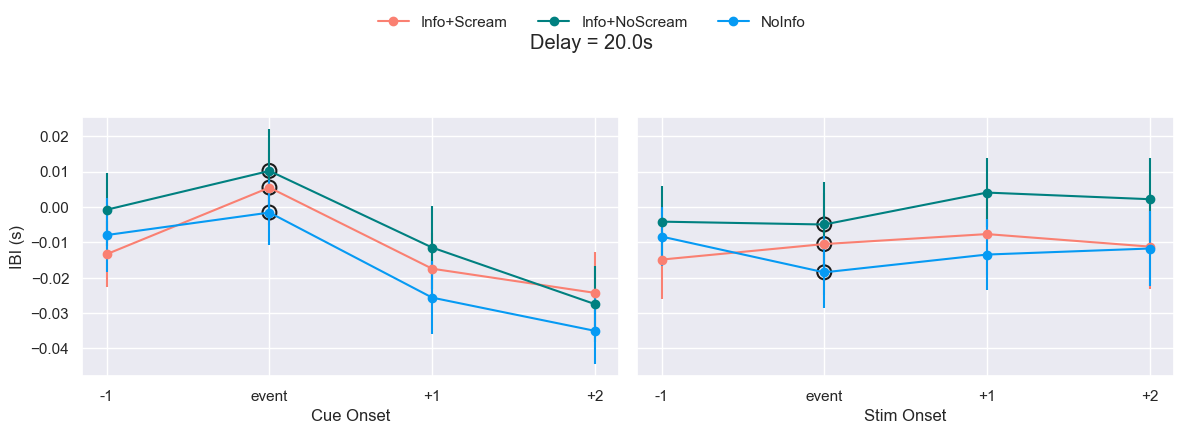

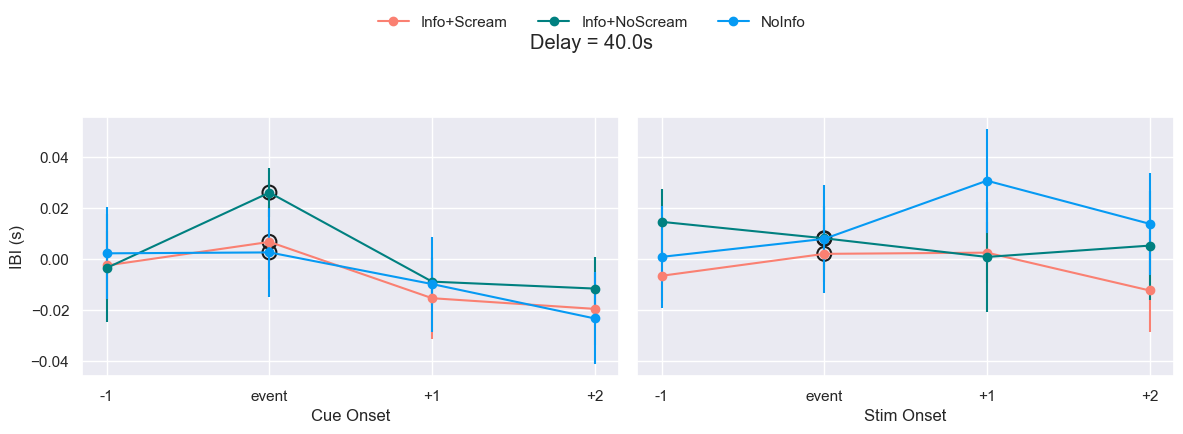

In [48]:
plot_event_beats(combined_beats_dict,cond_labels)

In [49]:
cond_labels_info = ['Info+Scream','Info+NoScream']
combined_beats_dict_info = {
    cond: all_beats_df[all_beats_df['condition'] == cond]
                 .reset_index(drop=True)
    for cond in cond_labels_info
}

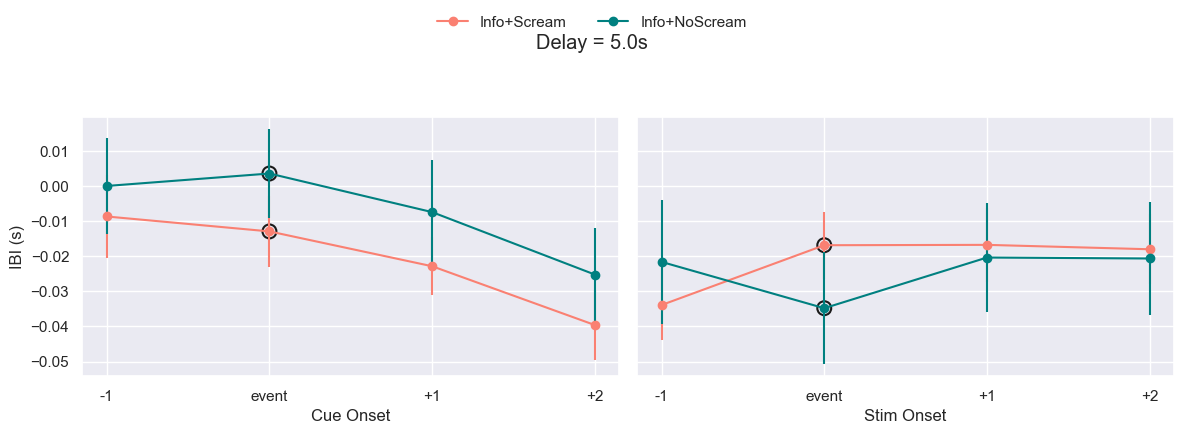

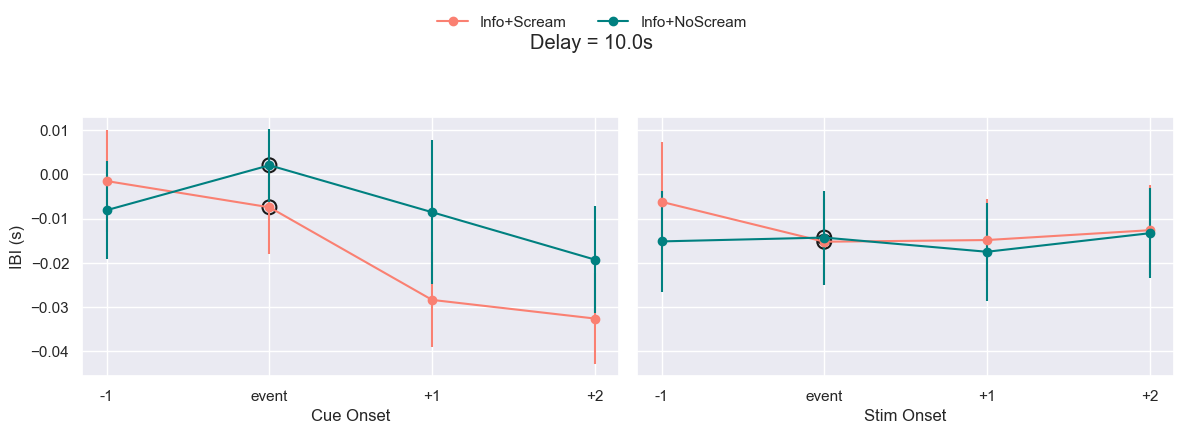

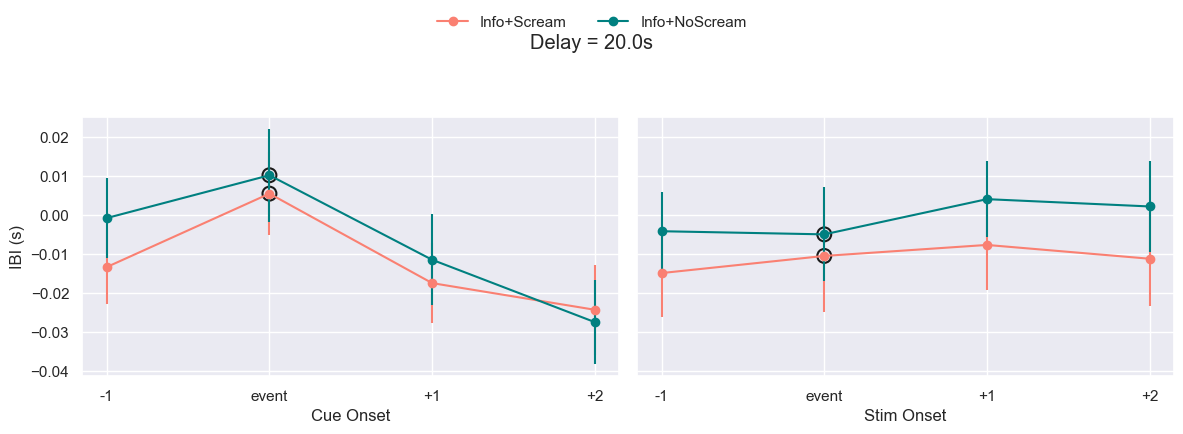

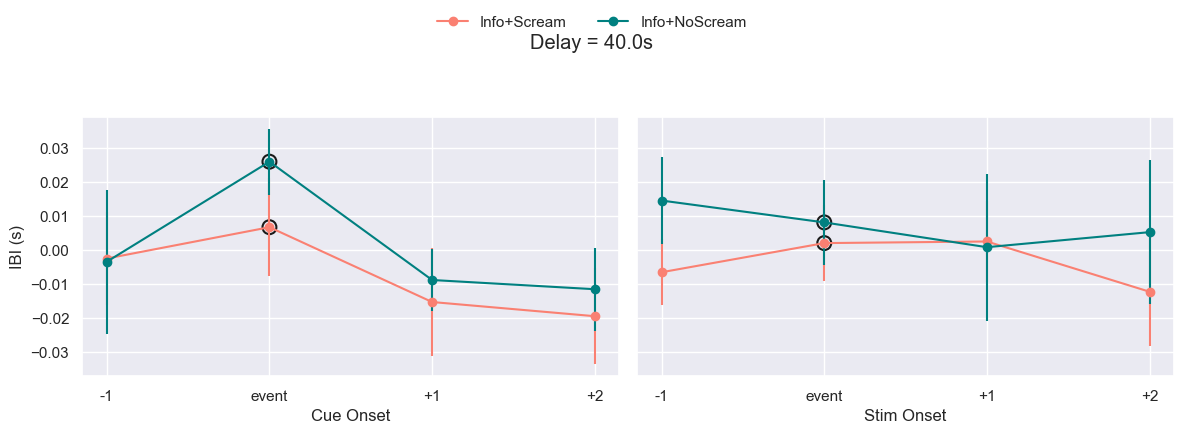

In [50]:
plot_event_beats(combined_beats_dict_info,cond_labels_info)

Using each beats - (B-1) explained in Skora paper

In [51]:
def compute_IBI_noBaseline (data):

    """
    Returns a DataFrame with one row per trial, containing:
      - participant, delay_time, PART_trial
      - IBIs: list of normalized IBIs (s)
      - time_norm: list of IBI timestamps relative to window start (s)
      - cue_norm, stim_norm: cue and stim onsets relative to window start (s)
      *** remove outliers with IBI values > 2 (some trials have recording issues)
    """
    rows = []

    for trials in data['PART_trial'].unique():
        trial_data = data[data['PART_trial']==trials]
        participant = trial_data['partNum'].iloc[0]
        delay = trial_data['delay_time'].iloc[0]

        #extract time point stimInfo or stimNoInfo is presented
        if 'stimInfoOnset' in trial_data.columns and trial_data['stimInfoOnset'].eq(1).any():
            cueTime = trial_data.loc[trial_data['stimInfoOnset']==1, 'time'].iloc[0]
        elif 'stimNoInfoOnset' in trial_data.columns and trial_data['stimNoInfoOnset'].eq(1).any():
            cueTime = trial_data.loc[trial_data['stimNoInfoOnset']==1, 'time'].iloc[0]
        else:
            cueTime = np.nan

        #extract time point scream or noScream is presented
        if 'screamOnset' in trial_data.columns and trial_data['screamOnset'].eq(1).any():
            stimTime = trial_data.loc[trial_data['screamOnset']==1,'time'].iloc[0]
        elif 'noScreamOnset' in trial_data.columns and trial_data['noScreamOnset'].eq(1).any():
            stimTime = trial_data.loc[trial_data['noScreamOnset']==1,'time'].iloc[0]    
        else:
            stimTime = np.nan

        #define start and end time of where ibi values will be extracted
        pre_window = 2.0 #adding 2 sec before infocue onset
        post_window = 4.0 #adding 4 sec after outcome stimulus presentation (outcome pres + end trial time)
        start = cueTime - pre_window
        end = stimTime + post_window

        
        # restrict to peaks in that window
        peak_times = trial_data.loc[trial_data['peak']==1, 'time'].values
        in_window = peak_times[(peak_times >= start) & (peak_times <= end)]
        if len(in_window) < 2:
            continue
        
        #compute raw and normalized ibis
        ibis      = np.diff(in_window)
        ibi_times = (in_window[:-1] + in_window[1:]) / 2

        # —— REMOVE OUTLIERS: drop any IBI > 2 seconds —— 
        mask = ibis < 2.0
        ibis = ibis[mask]
        ibi_times = ibi_times[mask]
        if len(ibis) == 0:
            # nothing left after filtering
            continue

        # —— normalize time to window start —— 
        t_norm     = (ibi_times - start).tolist()
        cue_norm   = cueTime   - start
        stim_norm  = stimTime  - start

        ibis_norm  = ibis.tolist()

        
        # get this trial’s delay_time (or whatever column you have)
        delay = trial_data['delay_time'].iloc[0]

        
        # collect one row per IBI
        rows.append({
            'participant': participant,
            'delay_time':  delay,
            'PART_trial':  trials,
            'IBIs':        ibis_norm,
            'time_norm':   t_norm,
            'cue_norm':    cue_norm,
            'stim_norm':   stim_norm
        })
        
    return pd.DataFrame(rows)

        
    

In [52]:
stimInfo_raw_scream_ibis = compute_IBI_noBaseline(stimInfo_scream_df)
stimInfo_raw_noScream_ibis = compute_IBI_noBaseline(stimInfo_noScream_df)
stimNoInfo_raw_ibis = compute_IBI_noBaseline(stimNoInfo_df)

In [53]:
def extract_event_norm_beats(df):
    """
    For each row in df, find the event indices (first beat after cue_norm & stim_norm),
    then extract a 4-beat window around each event (minus1, event, +1, +2),
    baseline-reference each window to its "minus1" beat (B-1 -> 0),
    and return a DataFrame with these normalized values plus metadata.
    """
    recs = []
    for _, row in df.iterrows():
        ibis  = np.array(row['IBIs'],     dtype=float)
        times = np.array(row['time_norm'], dtype=float)
        cue   = row['cue_norm']
        stim  = row['stim_norm']

        def window_norm(event_time, label_prefix):
            idxs = np.where(times > event_time)[0]
            if idxs.size == 0:
                vals = [np.nan]*4
            else:
                ev = idxs[0]
                window_idx = [ev-1, ev, ev+1, ev+2]
                vals = [ibis[i] if 0 <= i < len(ibis) else np.nan for i in window_idx]
            # baseline reference: subtract B-1
            b1 = vals[0]
            norm_vals = [(v - b1) if not np.isnan(v) else np.nan for v in vals]
            return dict(zip(
                [f"{label_prefix}_minus1", f"{label_prefix}_event", 
                 f"{label_prefix}_plus1", f"{label_prefix}_plus2"],
                norm_vals
            ))

        # extract and normalize windows
        cue_win  = window_norm(cue,  'cue')
        stim_win = window_norm(stim, 'stim')

        rec = {
            'participant': row['participant'],
            'delay_time':  row['delay_time'],
            'PART_trial':  row['PART_trial']
        }
        rec.update(cue_win)
        rec.update(stim_win)
        recs.append(rec)

    return pd.DataFrame(recs)


In [54]:
stimInfo_scream_norm_beats = extract_event_norm_beats(stimInfo_raw_scream_ibis)
stimInfo_noScream_norm_beats = extract_event_norm_beats(stimInfo_raw_noScream_ibis)
stimNoInfo_norm_beats = extract_event_norm_beats(stimNoInfo_raw_ibis)

In [55]:
# 1) Tag each with its condition
stimInfo_scream_norm_beats['condition']   = 'Info+Scream'
stimInfo_noScream_norm_beats['condition'] = 'Info+NoScream'
stimNoInfo_norm_beats['condition']        = 'NoInfo'

# 2) Concatenate, remove 2 sec trials
all_norm_beats_df = pd.concat([
    stimInfo_scream_norm_beats,
    stimInfo_noScream_norm_beats,
    stimNoInfo_norm_beats
], ignore_index=True)

all_norm_beats_df = all_norm_beats_df[all_norm_beats_df['delay_time'] !=2]

# 3) Convert to dict, keyed by condition
cond_labels = ['Info+Scream','Info+NoScream','NoInfo']
combined_norm_beats_dict = {
    cond: all_norm_beats_df[all_norm_beats_df['condition'] == cond]
                 .reset_index(drop=True)
    for cond in cond_labels
}


In [133]:

from scipy.stats import ttest_rel

def plot_event_norm_beats(extracted_dict, cond_labels):
    """
    Plot ibi difference values by separate delay times, around information cue and stimulus cue onset time.
    """
    # 1) Whitegrid style & custom palette
    sns.set_theme(style="whitegrid", font_scale=1.1)
    palette = {
        'Info+Scream': 'red',
        'Info+NoScream': 'green',
        'NoInfo':'blue'
    }

    cue_cols  = ['cue_minus1','cue_event','cue_plus1','cue_plus2']
    stim_cols = ['stim_minus1','stim_event','stim_plus1','stim_plus2']
    delays = sorted({dt for df in extracted_dict.values() for dt in df['delay_time'].unique()})

    for delay in delays:
        # 2) Build long‐form for cue & stim
        cue_frames, stim_frames = [], []
        for cond in cond_labels:
            df = extracted_dict[cond]
            df_d = df[df['delay_time']==delay]
            
            p_cue  = df_d.groupby('participant')[cue_cols ].mean().reset_index()
            p_stim = df_d.groupby('participant')[stim_cols].mean().reset_index()
            
            cue_long = p_cue.melt(id_vars='participant',
                                  value_vars=cue_cols,
                                  var_name='position',
                                  value_name='ibi')
            cue_long['condition'] = cond
            
            stim_long = p_stim.melt(id_vars='participant',
                                    value_vars=stim_cols,
                                    var_name='position',
                                    value_name='ibi')
            stim_long['condition'] = cond
            
            cue_frames.append(cue_long)
            stim_frames.append(stim_long)
        
        cue_df  = pd.concat(cue_frames,  ignore_index=True)
        stim_df = pd.concat(stim_frames, ignore_index=True)

        # 3) Map positions to labels
        label_map = {
            'cue_minus1':'-1','cue_event':'event','cue_plus1':'+1','cue_plus2':'+2',
            'stim_minus1':'-1','stim_event':'event','stim_plus1':'+1','stim_plus2':'+2'
        }
        for df_long in (cue_df, stim_df):
            df_long['pos_label'] = df_long['position'].map(label_map)
            df_long['pos_label'] = pd.Categorical(
                df_long['pos_label'],
                categories=['-1','event','+1','+2'],
                ordered=True
            )

        # 4) Plotting
        fig, (ax_cue, ax_stim) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

        sns.lineplot(
            data=cue_df, x='pos_label', y='ibi', hue='condition',
            marker='o', err_style="bars", errorbar="se",
            palette=palette, ax=ax_cue
        )
        sns.lineplot(
            data=stim_df, x='pos_label', y='ibi', hue='condition',
            marker='o', err_style="bars", errorbar="se",
            palette=palette, ax=ax_stim
        )

        # 5) Paired t‐test on the "event" beat for cue
        ev0 = cue_df[(cue_df['pos_label']=='event') & (cue_df['condition']==cond_labels[0])]
        ev1 = cue_df[(cue_df['pos_label']=='event') & (cue_df['condition']==cond_labels[1])]
        merged = pd.merge(
            ev0[['participant','ibi']],
            ev1[['participant','ibi']],
            on='participant',
            suffixes=('_0','_1')
        )
        t, p = ttest_rel(merged['ibi_0'], merged['ibi_1'], nan_policy='omit')
        if p < 0.05:
            stars = '***' if p < 0.001 else ('**' if p < 0.01 else '*')
            # determine top of error bars at event
            y_event = []
            for cond in cond_labels:
                vals = cue_df[(cue_df['pos_label']=='event') & (cue_df['condition']==cond)]['ibi']
                y_event.append(vals.mean() + vals.sem())
            y_max = max(y_event)
            ax_cue.text(1, y_max*1.02, stars, ha='center', va='bottom', fontsize=14)

        # 6) Final touches
        ax_cue.set_title(f'Cue Onset — Delay {delay}s')
        ax_stim.set_title(f'Stim Onset — Delay {delay}s')
        ax_cue.set_xlabel('')
        ax_stim.set_xlabel('')
        ax_cue.set_ylabel('Baseline-referenced IBI (s)')
        ax_stim.set_ylabel('')

        # shared legend at top
        handles, labels = ax_cue.get_legend_handles_labels()
        fig.legend(
            handles, labels,
            loc='upper center', bbox_to_anchor=(0.5,1.10),
            ncol=len(cond_labels), frameon=False
        )
        plt.tight_layout(rect=[0,0,1,0.90])
        plt.show()



In [122]:

from scipy.stats import ttest_rel, ttest_1samp

def plot_event_norm_beats(extracted_dict, cond_labels):
    """
    Seaborn lineplots of baseline-referenced IBI around cue & stim,
    with vertical SEM bars, and stars for:
      • within-condition vs. baseline (one-sample t-test vs 0)
      • between-condition (paired t-test)
    Stars are placed at a fixed relative height.
    """
    # 1) Seaborn style & custom palette
    sns.set_theme(style="whitegrid", font_scale=1.1)
    palette = {'Info+Scream': 'red', 'Info+NoScream': 'green', 'NoInfo':'blue'}

    cue_cols  = ['cue_minus1','cue_event','cue_plus1','cue_plus2']
    stim_cols = ['stim_minus1','stim_event','stim_plus1','stim_plus2']
    label_map = {
        **dict(zip(cue_cols,  ['-1','event','+1','+2'])),
        **dict(zip(stim_cols, ['-1','event','+1','+2']))
    }
    pos_order = ['-1','event','+1','+2']

    delays = sorted({dt for df in extracted_dict.values() for dt in df['delay_time'].unique()})
    for delay in delays:
        # Build long-form for cue & stim
        cue_frames, stim_frames = [], []
        for cond in cond_labels:
            df = extracted_dict[cond]
            df_d = df[df['delay_time'] == delay]
            p_cue  = df_d.groupby('participant')[cue_cols].mean().reset_index()
            p_stim = df_d.groupby('participant')[stim_cols].mean().reset_index()
            cue_long = p_cue.melt(id_vars='participant', value_vars=cue_cols,
                                  var_name='position', value_name='ibi')
            cue_long['condition'] = cond
            stim_long = p_stim.melt(id_vars='participant', value_vars=stim_cols,
                                    var_name='position', value_name='ibi')
            stim_long['condition'] = cond
            cue_frames.append(cue_long)
            stim_frames.append(stim_long)

        cue_df  = pd.concat(cue_frames, ignore_index=True)
        stim_df = pd.concat(stim_frames, ignore_index=True)

        # Map positions to labels
        for df_long in (cue_df, stim_df):
            df_long['pos_label'] = df_long['position'].map(label_map)
            df_long['pos_label'] = pd.Categorical(df_long['pos_label'],
                                                  categories=pos_order,
                                                  ordered=True)

        # Create subplots
        fig, (ax_cue, ax_stim) = plt.subplots(1, 2, figsize=(12,4), sharey=True)

        sns.lineplot(data=cue_df, x='pos_label', y='ibi', hue='condition',
                     marker='o', err_style="bars", errorbar="se",
                     palette=palette, ax=ax_cue, legend=False)
        sns.lineplot(data=stim_df, x='pos_label', y='ibi', hue='condition',
                     marker='o', err_style="bars", errorbar="se",
                     palette=palette, ax=ax_stim, legend=False)

        ax_cue.set_title(f'Cue Onset — Delay {delay}s')
        ax_stim.set_title(f'Stim Onset — Delay {delay}s')
        ax_cue.set_ylabel('Baseline-referenced IBI (s)')
        ax_stim.set_ylabel('')
        ax_cue.set_xlabel('')
        ax_stim.set_xlabel('')

        # Determine annotation heights
        ymin_c, ymax_c = ax_cue.get_ylim()
        ymin_s, ymax_s = ax_stim.get_ylim()
        offset_c = (ymax_c - ymin_c) * 0.05
        offset_s = (ymax_s - ymin_s) * 0.05
        y_within_c = ymax_c - offset_c
        y_between_c = ymax_c - 2*offset_c
        y_within_s = ymax_s - offset_s
        y_between_s = ymax_s - 2*offset_s

        # Within-condition vs baseline and between-condition
        for ax, df_long, y_within, y_between in [
            (ax_cue, cue_df, y_within_c, y_between_c),
            (ax_stim, stim_df, y_within_s, y_between_s)
        ]:
            # within-condition
            for cond in cond_labels:
                sub = df_long[df_long['condition']==cond]
                for pos in pos_order:
                    vals = sub[sub['pos_label']==pos]['ibi'].dropna()
                    if len(vals) > 1:
                        _, p = ttest_1samp(vals, 0, nan_policy='omit')
                        if p < 0.05:
                            x = pos_order.index(pos)
                            ax.text(x, y_within, '*', ha='center',
                                    va='bottom', color=palette[cond], fontsize=12)

            # between-condition
            for pos in pos_order:
                a = df_long[(df_long['condition']==cond_labels[0]) & (df_long['pos_label']==pos)]
                b = df_long[(df_long['condition']==cond_labels[1]) & (df_long['pos_label']==pos)]
                merged = pd.merge(a[['participant','ibi']], b[['participant','ibi']],
                                  on='participant', suffixes=('_0','_1'))
                if len(merged) > 1:
                    _, p = ttest_rel(merged['ibi_0'], merged['ibi_1'], nan_policy='omit')
                    if p < 0.05:
                        x = pos_order.index(pos)
                        ax.text(x, y_between, '*', ha='center',
                                va='bottom', color='black', fontsize=12)

        # Shared legend
        handles, labels = ax_cue.get_legend_handles_labels()
        fig.legend(handles, labels,
                   loc='upper center', bbox_to_anchor=(0.5,1.10),
                   ncol=len(cond_labels), frameon=False)

        plt.tight_layout(rect=[0,0,1,0.90])
        plt.show()



In [107]:

from scipy.stats import ttest_rel

def plot_event_norm_beats0(extracted_dict, cond_labels):
    """
    Seaborn-based plot of baseline-referenced IBI around cue & stim,
    with vertical SEM bars, and * showing significant adjacent-beat changes
    within each condition.
    """
    sns.set_theme(style="whitegrid", font_scale=1.1)
    palette = {'Info+Scream': 'red', 'Info+NoScream': 'green'}

    # Define columns and labels
    cue_cols  = ['cue_minus1','cue_event','cue_plus1','cue_plus2']
    stim_cols = ['stim_minus1','stim_event','stim_plus1','stim_plus2']
    label_map = {
        'cue_minus1':'-1','cue_event':'event','cue_plus1':'+1','cue_plus2':'+2',
        'stim_minus1':'-1','stim_event':'event','stim_plus1':'+1','stim_plus2':'+2'
    }
    pos_order = ['-1','event','+1','+2']

    # Delays
    delays = sorted({dt for df in extracted_dict.values() for dt in df['delay_time'].unique()})

    for delay in delays:
        # Create subplots
        fig, (ax_cue, ax_stim) = plt.subplots(1, 2, figsize=(12,4), sharey=True)
        fig.suptitle(f'Delay = {delay}s', y=1.02)

        for cond in cond_labels:
            df = extracted_dict[cond]
            df_d = df[df['delay_time'] == delay]
            
            # Participant-level means
            p_cue  = df_d.groupby('participant')[cue_cols].mean()
            p_stim = df_d.groupby('participant')[stim_cols].mean()
            
            # Mean ± SEM for plotting
            y_c = p_cue.mean().reset_index(drop=True)
            se_c = p_cue.sem().reset_index(drop=True)
            y_s = p_stim.mean().reset_index(drop=True)
            se_s = p_stim.sem().reset_index(drop=True)

            # Prepare DataFrame for seaborn
            cue_long = pd.DataFrame({
                'pos_label': pos_order,
                'mean': y_c,
                'sem': se_c,
                'condition': cond
            })
            stim_long = pd.DataFrame({
                'pos_label': pos_order,
                'mean': y_s,
                'sem': se_s,
                'condition': cond
            })

            # Plot mean line + SEM bars
            sns.lineplot(data=cue_long, x='pos_label', y='mean', hue='condition',
                         marker='o', err_style="bars", errorbar=("se", 1),
                         palette=palette, ax=ax_cue, legend=False)
            sns.lineplot(data=stim_long, x='pos_label', y='mean', hue='condition',
                         marker='o', err_style="bars", errorbar=("se", 1),
                         palette=palette, ax=ax_stim, legend=False)

            # Test adjacent beats within-condition
            for ax, p_df, y_vals in [
                (ax_cue, p_cue, y_c.values),
                (ax_stim, p_stim, y_s.values)
            ]:
                ymin, ymax = ax.get_ylim()
                offset = (ymax - ymin) * 0.05  # 5% of range
                for i in range(len(pos_order) - 1):
                    col1 = p_df.columns[i]
                    col2 = p_df.columns[i+1]
                    a = p_df[col1].dropna()
                    b = p_df[col2].dropna()
                    if len(a) > 1 and len(b) > 1:
                        t, p = ttest_rel(a, b, nan_policy='omit')
                        if p < 0.05:
                            x1, x2 = i, i+1
                            y_line = max(y_vals[i], y_vals[i+1]) + offset
                            # draw bracket line
                            ax.plot([x1, x1, x2, x2],
                                    [y_line, y_line+offset*0.2, y_line+offset*0.2, y_line],
                                    lw=1.5, color=palette[cond])
                            # draw star
                            ax.text((x1 + x2)/2,
                                    y_line + offset*0.2 + (offset*0.05),
                                    '*', ha='center', va='bottom',
                                    color=palette[cond], fontsize=14)

        # Final axis settings
        for ax, title in zip((ax_cue, ax_stim), ('Cue Onset', 'Stim Onset')):
            ax.set_title(title)
            ax.set_xlabel('')
        ax_cue.set_ylabel('Baseline-referenced IBI (s)')
        ax_stim.set_ylabel('')

        # Legend at top
        handles, labels = ax_cue.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center',
                   bbox_to_anchor=(0.5,1.10), ncol=len(cond_labels), frameon=False)

        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()



In [142]:
# Updated plotting function with vertical error bars
def plot_event_beats_groupedDelay(extracted_dict,
                                  cond_labels):
    """
    For each delay group (short vs. long) and each condition:
      1) Compute each participant's mean normalized 4-beat window
      2) Across participants → grand mean ± SEM
      3) Plot cue & stim windows side-by-side using seaborn with vertical error bars
    """
    # Define delay groups
    groups = {
        'Short delay (5-10 s)': [5.0, 10.0],
        'Long  delay (20-40 s)': [20.0, 40.0]
    }

    # whitegrid style and custom palette 
    sns.set_theme(style="whitegrid", font_scale=1.1)
    color_map = {
        'Info+Scream': 'red',
        'Info+NoScream': 'green',
        'NoInfo': 'blue'
    }

    pos_map = {'minus1': -1, 'event': 0, 'plus1': 1, 'plus2': 2}
    positions = ['minus1', 'event', 'plus1', 'plus2']
    xticks = [pos_map[p] for p in positions]
    xticklabels = ['-1', 'event', '+1', '+2']

    for grp_name, delays in groups.items():
        fig, (ax_cue, ax_stim) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

        for cond in cond_labels:
            df = extracted_dict.get(cond, pd.DataFrame())
            df_grp = df[df['delay_time'].isin(delays)]

            cue_cols  = [f"cue_{p}" for p in positions]
            stim_cols = [f"stim_{p}" for p in positions]
            p_cue  = df_grp.groupby('participant')[cue_cols].mean().reset_index()
            p_stim = df_grp.groupby('participant')[stim_cols].mean().reset_index()

            long_cue = (
                p_cue.melt(id_vars='participant', value_vars=cue_cols,
                           var_name='position', value_name='ibi')
                     .assign(position=lambda d: d['position'].str.replace('cue_', ''))
                     .assign(pos_num=lambda d: d['position'].map(pos_map))
            )
            long_stim = (
                p_stim.melt(id_vars='participant', value_vars=stim_cols,
                            var_name='position', value_name='ibi')
                      .assign(position=lambda d: d['position'].str.replace('stim_', ''))
                      .assign(pos_num=lambda d: d['position'].map(pos_map))
            )

            # Vertical error bars (capsize adds horizontal caps at error line ends)
            sns.pointplot(
                data=long_cue, x='pos_num', y='ibi', estimator='mean', errorbar='se',
                color=color_map[cond], markers='o', linestyles='-',
                capsize=0.1, err_kws={'linewidth': 1.5}, label=cond, ax=ax_cue
            )
            sns.pointplot(
                data=long_stim, x='pos_num', y='ibi', estimator='mean', errorbar='se',
                color=color_map[cond], markers='o', linestyles='-',
                capsize=0.1, err_kws={'linewidth': 1.5}, ax=ax_stim
            )

            event_c = p_cue['cue_event'].mean()
            event_s = p_stim['stim_event'].mean()
            ax_cue.scatter(positions.index('event'), event_c, s=100,
                           facecolors='none', edgecolors='k', linewidths=1.5)
            ax_stim.scatter(positions.index('event'), event_s, s=100,
                            facecolors='none', edgecolors='k', linewidths=1.5)

        for ax, title in zip((ax_cue, ax_stim), ('Cue Onset', 'Stimulus Onset')):
            ax.set_xticks(range(len(positions)))
            ax.set_xticklabels(xticklabels)
            ax.set_xlabel(title)
            ax.grid(True)
        ax_cue.set_ylabel('Baseline-referenced IBI (s)')
        fig.suptitle(grp_name, y=1.02)

        handles, labels = ax_cue.get_legend_handles_labels()
        fig.legend(handles, labels,
                   loc='upper center', bbox_to_anchor=(0.5, 1.10),
                   ncol=len(cond_labels), frameon=False)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


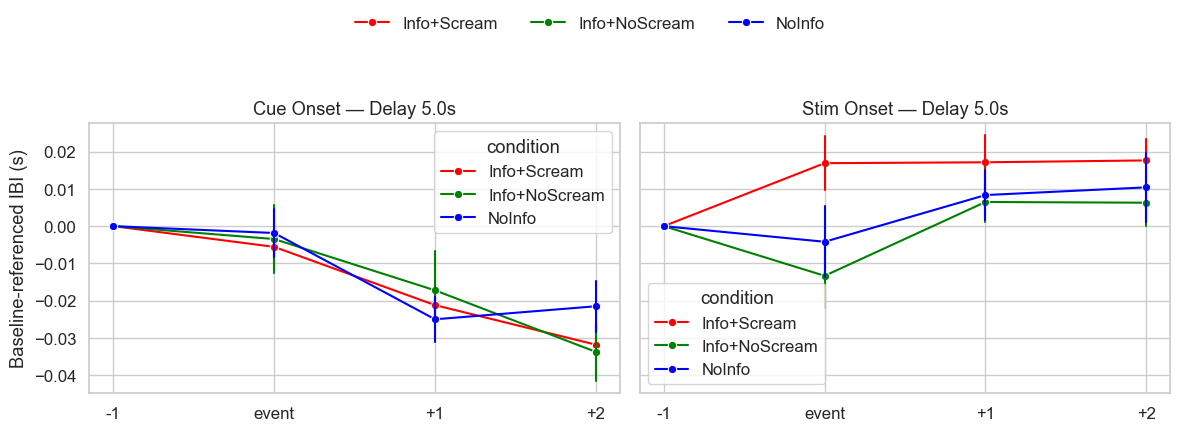

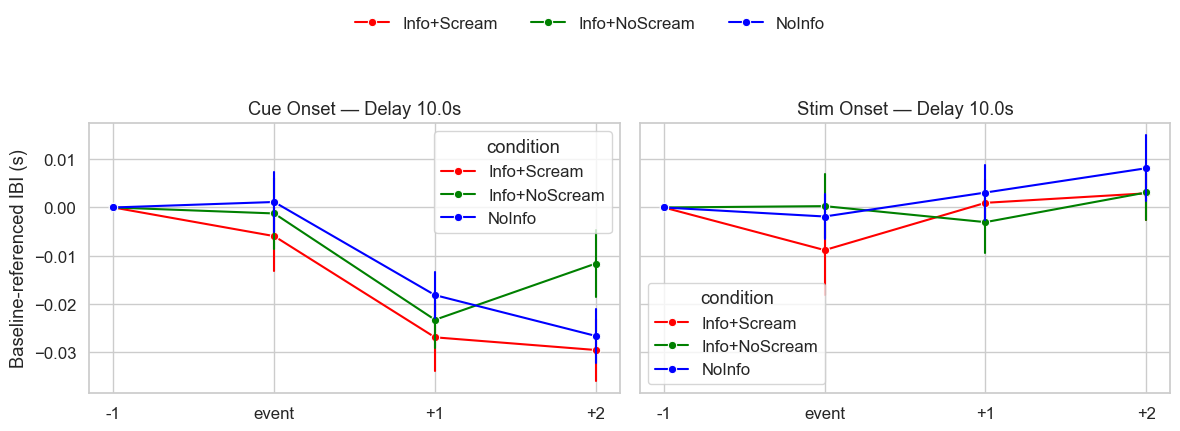

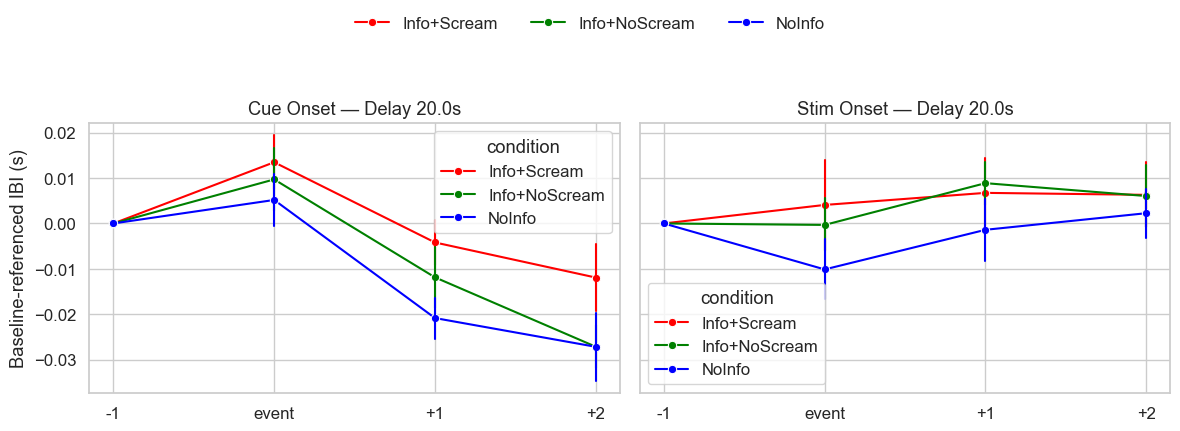

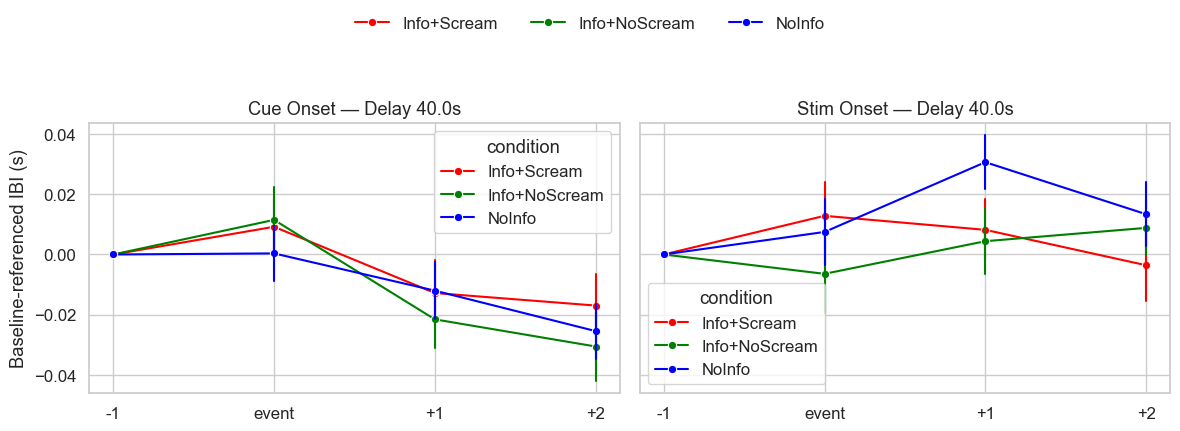

In [135]:
plot_event_norm_beats(combined_norm_beats_dict,cond_labels)

In [136]:
cond_labels_info = ['Info+Scream','Info+NoScream']
combined_norm_beats_dict_info = {
    cond: all_norm_beats_df[all_norm_beats_df['condition'] == cond]
                 .reset_index(drop=True)
    for cond in cond_labels_info
}

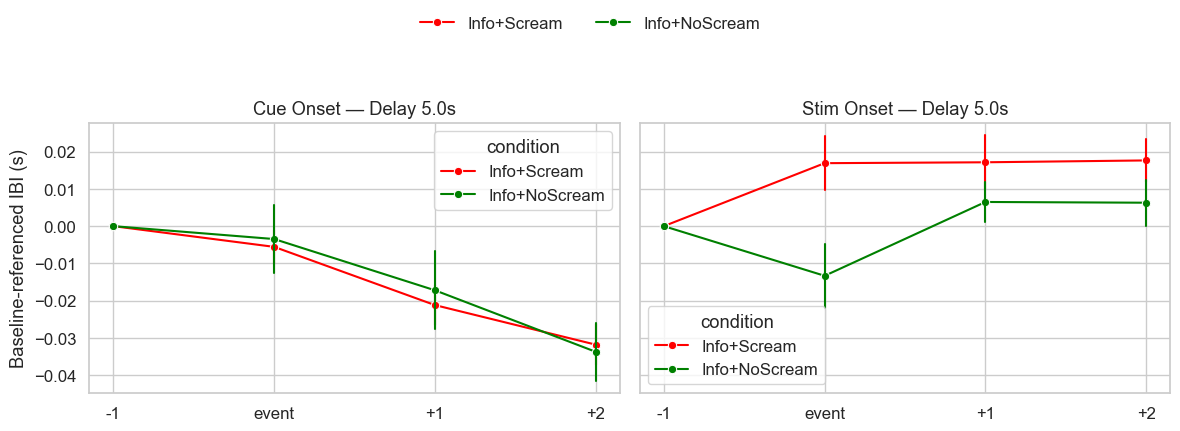

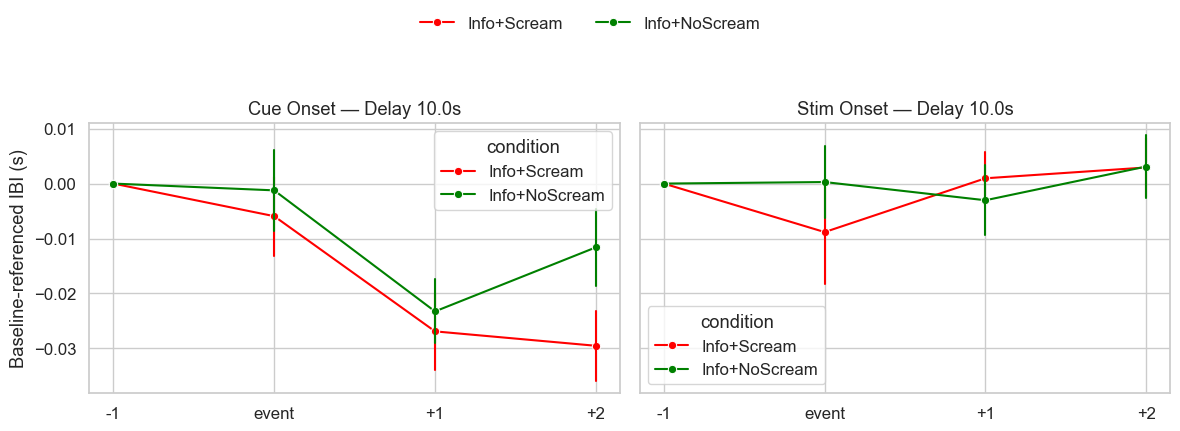

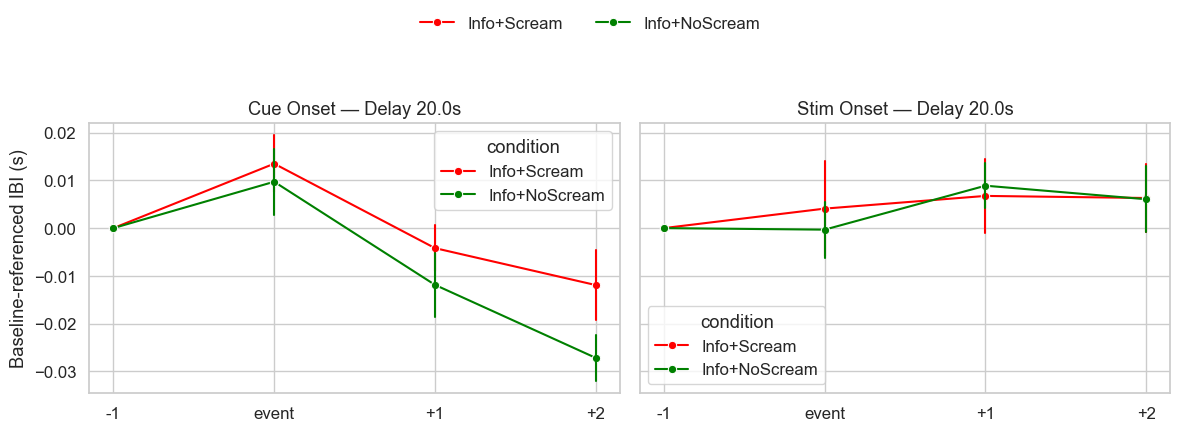

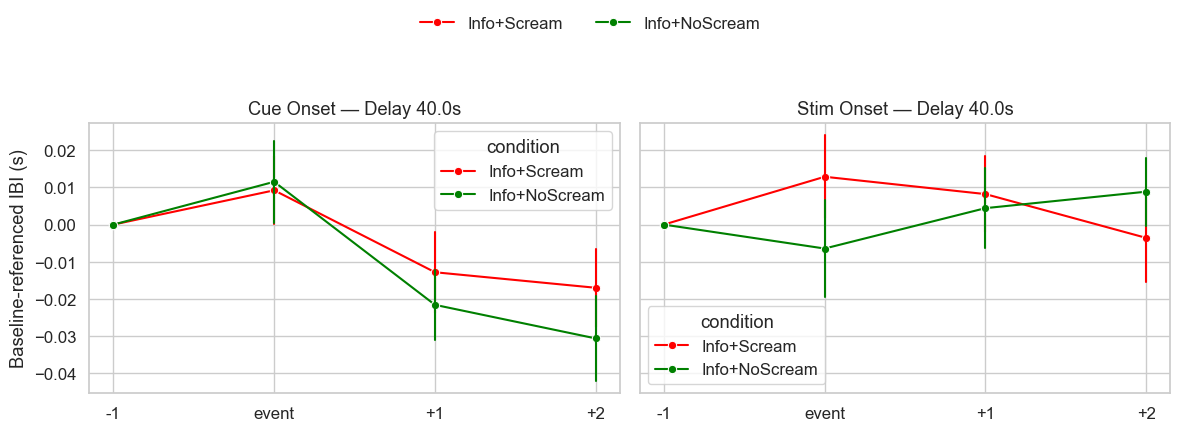

In [137]:
plot_event_norm_beats(combined_norm_beats_dict_info,cond_labels_info)

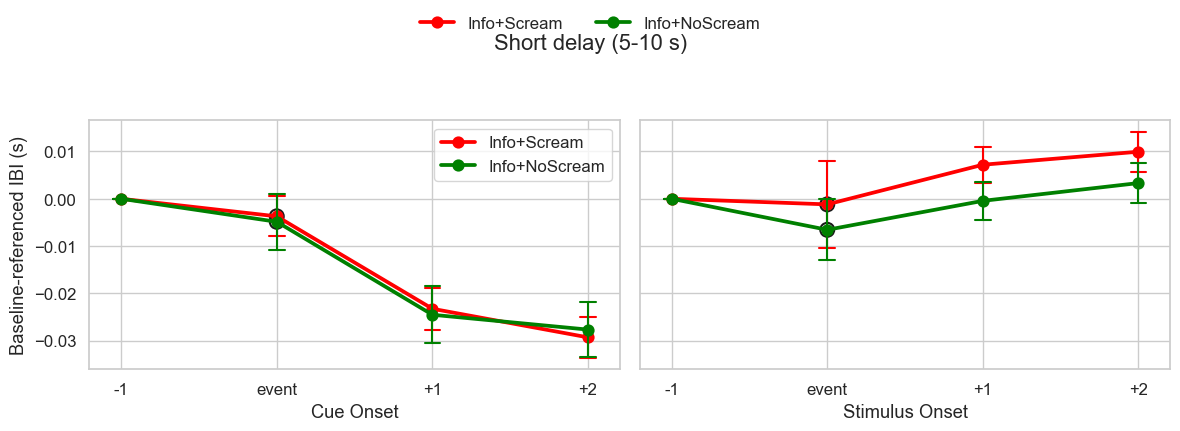

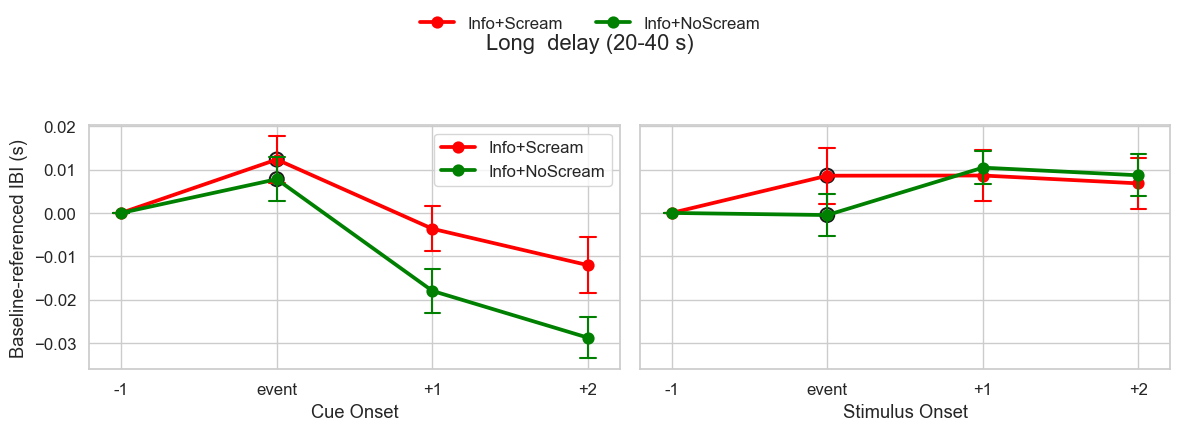

In [ ]:
plot_event_beats_groupedDelay(combined_norm_beats_dict_info,cond_labels_info)

In [144]:
cond_labels_info = ['Info+Scream','Info+NoScream', 'NoInfo']
combined_norm_beats_dict_info = {
    cond: all_norm_beats_df[all_norm_beats_df['condition'] == cond]
                 .reset_index(drop=True)
    for cond in cond_labels_info
}

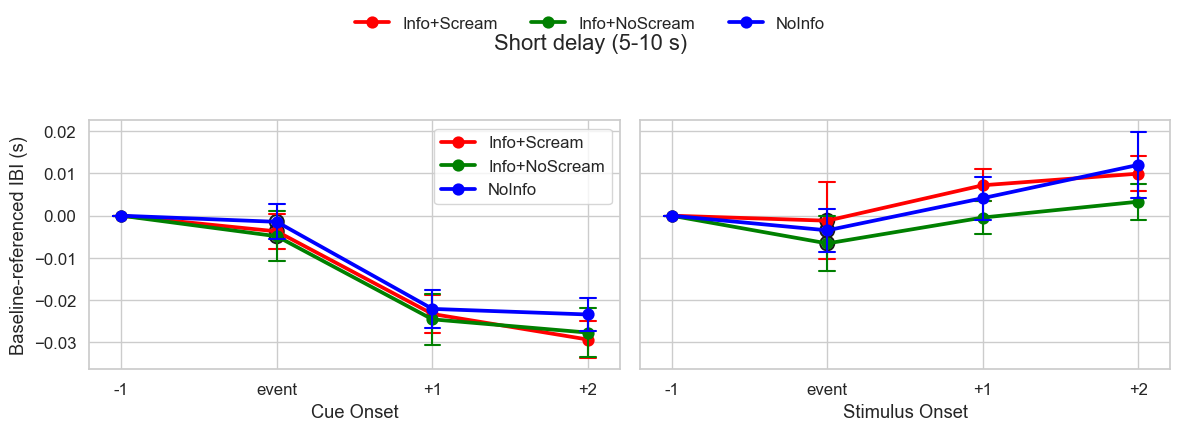

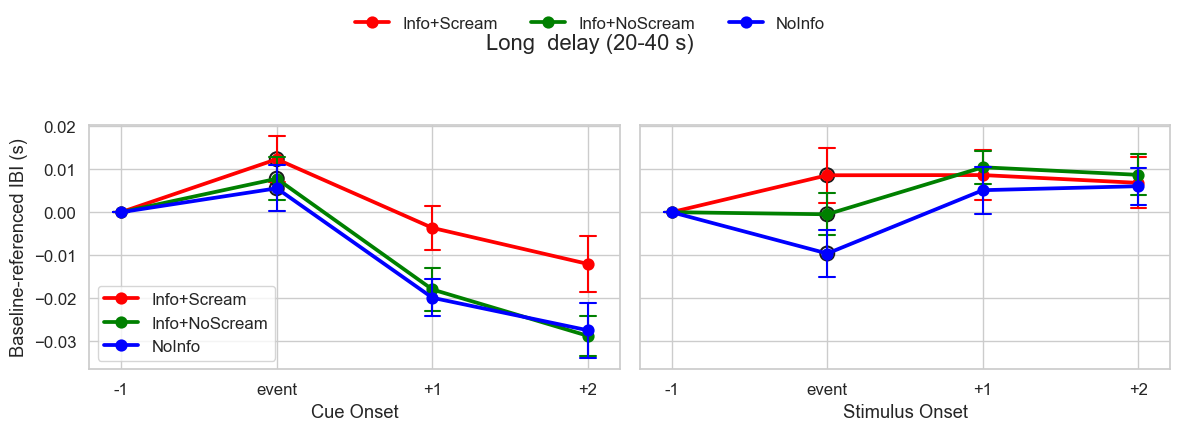

In [146]:
plot_event_beats_groupedDelay(combined_norm_beats_dict_info,cond_labels_info)

### info vs no info

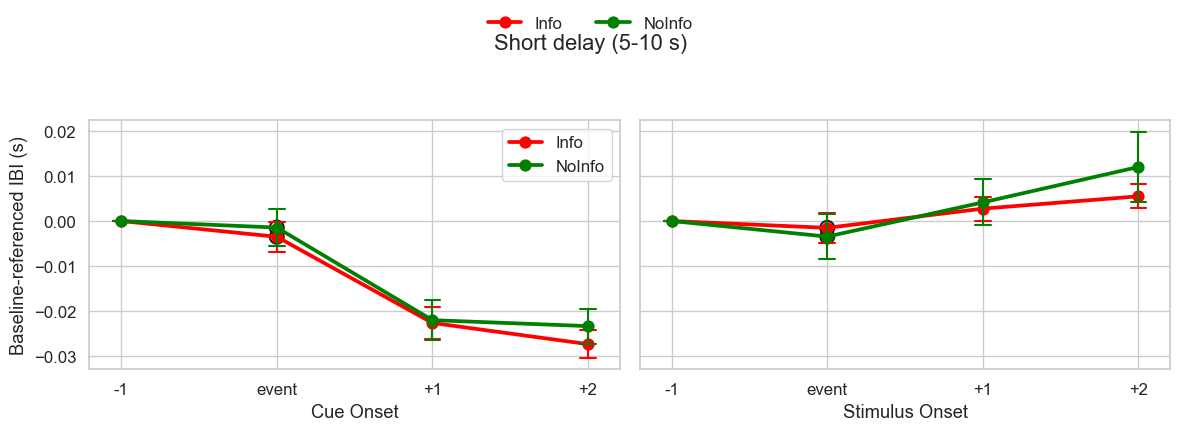

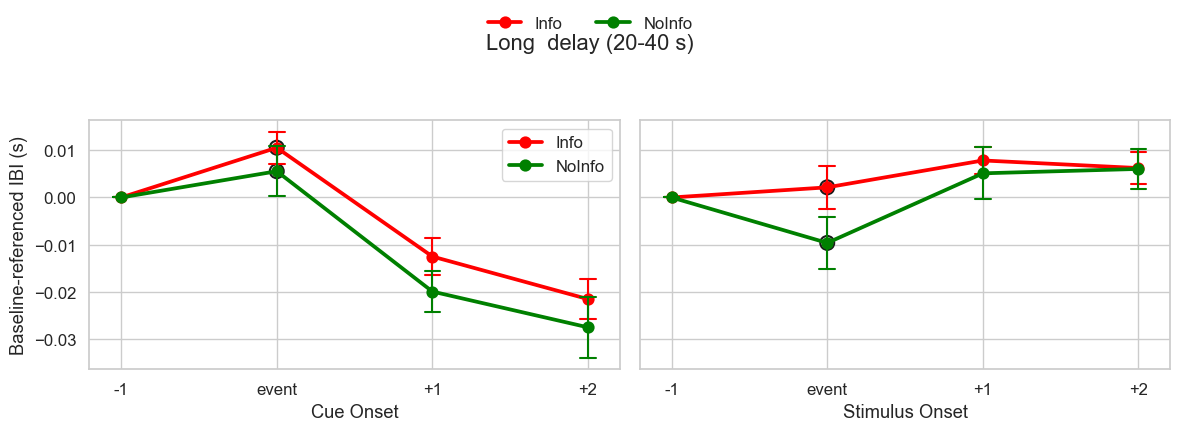

In [ ]:
# Updated plotting function combining conditions

def plot_event_beats_groupedDelay_combined(extracted_dict):
    """
    Combine Info+Scream and Info+NoScream into Info, and plot Info vs NoInfo.
    """
    groups = {
        'Short delay (5-10 s)': [5.0, 10.0],
        'Long  delay (20-40 s)': [20.0, 40.0]
    }

    sns.set_theme(style="whitegrid", font_scale=1.1)
    color_map = {
        'Info': 'red',
        'NoInfo': 'green'
    }

    pos_map = {'minus1': -1, 'event': 0, 'plus1': 1, 'plus2': 2}
    positions = ['minus1', 'event', 'plus1', 'plus2']
    xticklabels = ['-1', 'event', '+1', '+2']

    for grp_name, delays in groups.items():
        fig, (ax_cue, ax_stim) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

        combined_dict = {
            'Info': pd.concat([extracted_dict['Info+Scream'], extracted_dict['Info+NoScream']]),
            'NoInfo': extracted_dict['NoInfo']
        }

        for cond, df in combined_dict.items():
            df_grp = df[df['delay_time'].isin(delays)]

            cue_cols = [f"cue_{p}" for p in positions]
            stim_cols = [f"stim_{p}" for p in positions]
            p_cue = df_grp.groupby('participant')[cue_cols].mean().reset_index()
            p_stim = df_grp.groupby('participant')[stim_cols].mean().reset_index()

            long_cue = (
                p_cue.melt(id_vars='participant', value_vars=cue_cols,
                           var_name='position', value_name='ibi')
                     .assign(position=lambda d: d['position'].str.replace('cue_', ''))
                     .assign(pos_num=lambda d: d['position'].map(pos_map))
            )
            long_stim = (
                p_stim.melt(id_vars='participant', value_vars=stim_cols,
                            var_name='position', value_name='ibi')
                      .assign(position=lambda d: d['position'].str.replace('stim_', ''))
                      .assign(pos_num=lambda d: d['position'].map(pos_map))
            )

            sns.pointplot(
                data=long_cue, x='pos_num', y='ibi', estimator='mean', errorbar='se',
                color=color_map[cond], markers='o', linestyles='-', capsize=0.1,
                err_kws={'linewidth': 1.5}, label=cond, ax=ax_cue
            )
            sns.pointplot(
                data=long_stim, x='pos_num', y='ibi', estimator='mean', errorbar='se',
                color=color_map[cond], markers='o', linestyles='-', capsize=0.1,
                err_kws={'linewidth': 1.5}, ax=ax_stim
            )

            event_c = p_cue['cue_event'].mean()
            event_s = p_stim['stim_event'].mean()
            ax_cue.scatter(positions.index('event'), event_c, s=100,
                           facecolors='none', edgecolors='k', linewidths=1.5)
            ax_stim.scatter(positions.index('event'), event_s, s=100,
                            facecolors='none', edgecolors='k', linewidths=1.5)

        for ax, title in zip((ax_cue, ax_stim), ('Cue Onset', 'Stimulus Onset')):
            ax.set_xticks(range(len(positions)))
            ax.set_xticklabels(xticklabels)
            ax.set_xlabel(title)
            ax.grid(True)

        ax_cue.set_ylabel('Baseline-referenced IBI (s)')
        fig.suptitle(grp_name, y=1.02)

        handles, labels = ax_cue.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.10),
                   ncol=2, frameon=False)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Prepare your combined dictionary
cond_labels_info = ['Info+Scream', 'Info+NoScream', 'NoInfo']
combined_norm_beats_dict_info = {
    cond: all_norm_beats_df[all_norm_beats_df['condition'] == cond]
                 .reset_index(drop=True)
    for cond in cond_labels_info
}

plot_event_beats_groupedDelay_combined(combined_norm_beats_dict_info)
